# 수정사항

1. 기존에는 가격값이 결측치가 포함된 상태에서 시각화를 진행했는데 결측치가 포함된 가격값에 대해서 이상치 보려고 했을때 박스플롯이 생성되지않는 오류가있어서 가격값 결측치 분리하는 코드를 앞으로 당겼음.
2. 이상치 판단하기 위한 시각화 코드 추가
3. 이상치 제거 코드 추가(가격)
4. 가격값과 엔진 값에 로그 변환해줘서 데이터 정규성 띌수 있도록 변환해줌
5. 변수간 상관도 볼수 있는 코드 추가

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randn

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportions_ztest

import graphviz
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

matplotlib.rc('font', family = 'NanumBarunGothic')
matplotlib.rc('axes', unicode_minus = False)

### 타겟변수
- Price : 중고차 가격(단위:천원)

### 설명변수
- Name : 자동차 브랜드, 모델
- Location : 영업점 위치
- Year : 모델 연식
- Kilometers_Driven : 차량 누적 주행거리(Km)
- Fuel_Type : 자동차 사용연료
- Transmission : 변속방식(Manual/Automatic)
- Owner_Type : 소유권한 여부
- Mileage : 표준주행거리(kmpl)
- Engine : 엔진배기량(cc)
- Power : 엔진최대출력(bhp)
- Seats : 좌석 수
- New_Price : 신차 가격

In [2]:
def classify_city_income(city_name):
    high_income = {
        "Mumbai": "High",
        "Delhi": "High",
        "Bangalore": "High",
        "Chennai": "High"}

    mid_income = {
        "Hyderabad": "Median",
        "Ahmedabad": "Median",
        "Pune": "Median",
        "Kolkata": "Median",
        "Coimbatore": "Median"}
    
    low_income = {
        "Jaipur": "Low",
        "Kochi": "Low"}
    
    city_name = city_name.strip()
    
    if city_name in high_income:
        return high_income[city_name]
    elif city_name in mid_income:
        return mid_income[city_name]
    elif city_name in low_income:
        return low_income[city_name]
    else:
        return np.nan
    
    
def classify_car_by_seats(seat_count):
    if seat_count == 2:
        return "Sports Car"
    elif seat_count == 4:
        return "Sedan"
    elif seat_count == 5:
        return "Standard Car"
    elif seat_count in (6, 7):
        return "SUV"
    else:
        return "Large Vehicle"
    
brand_categories = {
    'Audi': 'Luxury', 'BMW': 'Luxury', 'Mercedes-Benz': 'Luxury', 'Jaguar': 'Luxury', 'Porsche': 'Luxury', 'Bentley': 'Luxury', 'Lamborghini': 'Luxury',
    'Volvo': 'Premium', 'Land': 'Premium', 'Mini': 'Premium', 'Smart': 'Premium',
    'Toyota': 'Mainstream', 'Honda': 'Mainstream', 'Hyundai': 'Mainstream', 'Nissan': 'Mainstream', 'Volkswagen': 'Mainstream', 'Ford': 'Mainstream', 'Chevrolet': 'Mainstream',
    'Maruti': 'Economy', 'Tata': 'Economy', 'Mahindra': 'Economy', 'Datsun': 'Economy', 'Fiat': 'Economy', 'Renault': 'Economy', 'Skoda': 'Economy', 'Jeep': 'Economy', 'OpelCorsa': 'Economy',
    'ISUZU': 'Commercial/Utility', 'Force': 'Commercial/Utility', 'Hindustan': 'Commercial/Utility', 'Ambassador': 'Commercial/Utility', 'Mitsubishi': 'Mainstream'}

In [3]:
df = pd.read_csv("/home/piai/다운로드/01_실습파일/2. Big Data 분석/Car.csv")
df.shape

(7253, 13)

In [4]:
df['Engine'] = df['Engine'].replace(['null', '0 CC'], np.nan).astype(str).str.replace(' CC', '').astype(float)
df['Power'] = df['Power'].replace(['null bhp', '0 bhp'], np.nan).astype(str).str.replace(' bhp', '').astype(float)
df['Mileage'] = df['Mileage'].replace('null kmpl', np.nan).astype(str).str.replace(' kmpl', '').astype(str).str.replace(' km/kg', '').astype(float)

In [5]:
Owner_Type = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4}
df['Owner_Type_Num'] = df['Owner_Type'].map(Owner_Type)

In [6]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Owner_Type_Num
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,1
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,1
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,1
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   float64
 9   Engine             7207 non-null   float64
 10  Power              7078 non-null   float64
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Owner_Type_Num     7253 non-null   int64  
dtypes: float64(5), int64(3), object(6)
memory usage: 793.4+ KB


In [8]:
df.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_Num
count,6200.000000,7253.000000,7.253000e+03,7251.000000,7207.000000,7078.000000,7200.000000,7253.000000
mean,14912.514750,2013.365366,5.869906e+04,18.141580,1616.573470,112.765214,5.279722,1.201572
std,17674.318464,3.254421,8.442772e+04,4.562197,595.285137,53.493553,0.811660,0.456808
min,7.080000,1996.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,1.000000
25%,5365.360000,2011.000000,3.400000e+04,15.170000,1198.000000,75.000000,5.000000,1.000000
50%,8814.520000,2014.000000,5.341600e+04,18.160000,1493.000000,94.000000,5.000000,1.000000
75%,15869.972500,2016.000000,7.300000e+04,21.100000,1968.000000,138.100000,5.000000,1.000000
max,245273.600000,2019.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000,4.000000


In [9]:
df.describe(include = 'object')

,Name,Location,Fuel_Type,Transmission,Owner_Type,New_Price
count,7253,7253,7253,7253,7253,1006
unique,2041,11,5,2,4,625
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,63.71 Lakh
freq,55,949,3852,5204,5952,6


> 약 7300개의 데이터 행개수의 대다수가 널값인 New_Price 열은 지워주었습니다

In [10]:
df.drop(labels = 'New_Price', axis = 1, inplace = True)

> Engine과 Power 값의 경우 회귀모델을 설계하여 널값을 제외한 값들로 학습시키고 비어있는 값들을 에측하여 넣어주었습니다. 200개정도의 널값이 있었기에 과적합의 우려가 적을것이라 판단했습니다.

In [11]:
missing_engine_indices = df[df['Engine'].isnull() | (df['Engine'] == 0)].index

imputer = SimpleImputer(strategy='mean')
df[['Engine', 'Power', 'Mileage']] = imputer.fit_transform(df[['Engine', 'Power', 'Mileage']])

engine_data = df[['Engine', 'Power', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
engine_data = pd.get_dummies(engine_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = engine_data[engine_data['Engine'].notnull() | (engine_data['Engine'] == 0)]
predict_data = engine_data.loc[missing_engine_indices]

X_train = train_data.drop('Engine', axis=1)
y_train = train_data['Engine']
X_predict = predict_data.drop('Engine', axis=1)

if not X_predict.empty:
    engine_model = RandomForestRegressor(n_estimators=100, random_state=42)
    engine_model.fit(X_train, y_train)

    predicted_engines = engine_model.predict(X_predict)
    df.loc[missing_engine_indices, 'Engine'] = predicted_engines

In [12]:
missing_power_indices = df[df['Power'].isnull() | (df['Power'] == 0)].index

power_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
power_data = pd.get_dummies(power_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = power_data[power_data['Power'].notnull()| (engine_data['Power'] == 0)]
predict_data = power_data.loc[missing_power_indices]

X_train = train_data.drop('Power', axis=1)
y_train = train_data['Power']
X_predict = predict_data.drop('Power', axis=1)

if not X_predict.empty:
    power_model = RandomForestRegressor(n_estimators=100, random_state=42)
    power_model.fit(X_train, y_train)

    predicted_powers = power_model.predict(X_predict)
    df.loc[missing_power_indices, 'Power'] = predicted_powersMaruti

In [13]:
# missing_mileage_indices = df[df['Mileage'].isnull() | (df['Mileage'] == 0)].index

# mileage_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
# mileage_data = pd.get_dummies(mileage_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

# train_data = mileage_data[mileage_data['Mileage'].notnull() | (engine_data['Mileage'] == 0)]
# predict_data = mileage_data.loc[missing_mileage_indices]

# X_train = train_data.drop('Mileage', axis=1)
# y_train = train_data['Mileage']
# X_predict = predict_data.drop('Mileage', axis=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# if not X_predict.empty:
#     param_grid = {
#         'n_estimators': [50 * i for i in range(1, 6)], 
#         'max_depth': [i for i in range(1, 11)],
#         'min_samples_split': [10 * i for i in range(1, 11)], 
#         'min_samples_leaf': [5 * i for i in range(1, 6)]
#     }

#     grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(X_train, y_train)

#     best_params = grid_search.best_params_
#     print("Best Parameters:", best_params)

#     best_model = grid_search.best_estimator_
#     predicted_mileages = best_model.predict(X_predict)

#     df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

In [14]:
missing_mileage_indices = df[df['Mileage'].isnull() | (df['Mileage'] == 0)].index

mileage_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
mileage_data = pd.get_dummies(mileage_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = mileage_data[mileage_data['Mileage'].notnull() | (engine_data['Mileage'] == 0)]
predict_data = mileage_data.loc[missing_mileage_indices]

X_train = train_data.drop('Mileage', axis=1)
y_train = train_data['Mileage']
X_predict = predict_data.drop('Mileage', axis=1)

if not X_predict.empty:
    mileages_model = RandomForestRegressor(max_depth = 10, min_samples_leaf = 5, min_samples_split = 10, n_estimators = 250, random_state=42)
    mileages_model.fit(X_train, y_train)
    
    predicted_mileages = mileages_model.predict(X_predict)
    df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

In [15]:
# val_predictions = best_model.predict(X_val)
# print("Validation MAE:", mean_absolute_error(y_val, val_predictions))
# print("Validation MSE:", mean_squared_error(y_val, val_predictions))
# print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_predictions)))
# print("Validation R^2 Score:", r2_score(y_val, val_predictions))

# predicted_mileages = best_model.predict(X_predict)
# df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

In [16]:
# missing_mileage_indices = df[df['Mileage'].isnull() | (df['Mileage'] == 0)].index

# mean_mileage = df[df['Mileage'] > 0]['Mileage'].mean()

# df.loc[missing_mileage_indices, 'Mileage'] = mean_mileage

In [17]:
df['Year'] = 2024 - df['Year']

In [18]:
df['Location_income'] = df['Location'].apply(classify_city_income)
df['Car_cate'] = df['Seats'].apply(classify_car_by_seats)
df['Brand'] = df['Name'].apply(lambda x :x.split()[0])

In [19]:
df['Brand_Category'] = df['Brand'].str.split().str[0].map(brand_categories).fillna('Unknown')

> Seats 값의 경우 7인 모델하나를 제외하고 나머지 모델은 전부 5인승이기에 서칭한 데이터를 기반으로 값을 넣어주었습니다.

In [20]:
condition = (df['Seats'].isnull() & (df['Name'] == 'Mahindra TUV 300 P4'))
df.loc[condition, 'Seats'] = 7

condition1 = (df['Seats'].isnull() & (df['Name'] != 'Mahindra TUV 300 P4'))
df.loc[condition1, 'Seats'] = 5

df.loc[3999, 'Seats'] = 5

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7253 non-null   float64
 9   Engine             7253 non-null   float64
 10  Power              7253 non-null   float64
 11  Seats              7253 non-null   float64
 12  Owner_Type_Num     7253 non-null   int64  
 13  Location_income    7253 non-null   object 
 14  Car_cate           7253 non-null   object 
 15  Brand              7253 non-null   object 
 16  Brand_Category     7253 

In [22]:
df.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_Num
count,6200.000000,7253.000000,7.253000e+03,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000
mean,14912.514750,10.634634,5.869906e+04,18.225855,1616.238304,112.765214,5.278643,1.201572
std,17674.318464,3.254421,8.442772e+04,4.305160,593.439536,52.844178,0.806915,0.456808
min,7.080000,5.000000,1.710000e+02,2.039230,72.000000,34.200000,2.000000,1.000000
25%,5365.360000,8.000000,3.400000e+04,15.200000,1198.000000,77.000000,5.000000,1.000000
50%,8814.520000,10.000000,5.341600e+04,18.160000,1493.000000,98.600000,5.000000,1.000000
75%,15869.972500,13.000000,7.300000e+04,21.100000,1968.000000,138.030000,5.000000,1.000000
max,245273.600000,28.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000,4.000000


In [23]:
df.describe(include = 'object')

,Name,Location,Fuel_Type,Transmission,Owner_Type,Location_income,Car_cate,Brand,Brand_Category
count,7253,7253,7253,7253,7253,7253,7253,7253,7253
unique,2041,11,5,2,4,3,5,32,5
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,Median,Standard Car,Maruti,Mainstream
freq,55,949,3852,5204,5952,3342,6047,1444,3619


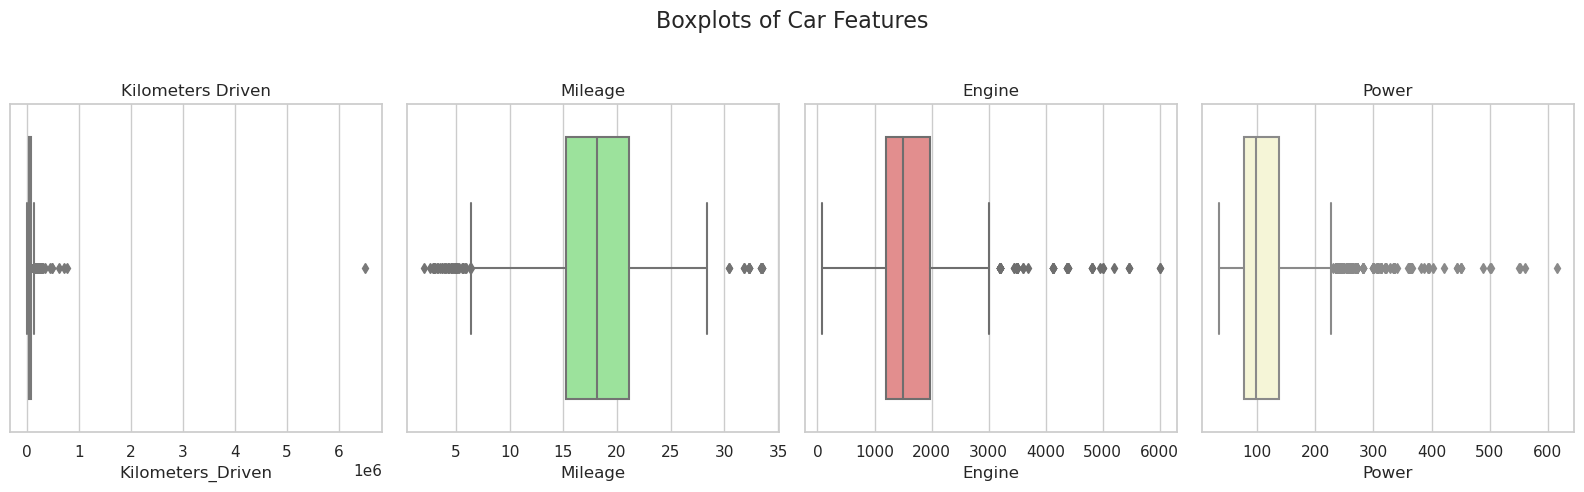

In [24]:
sns.set(style="whitegrid")

# 서브플롯 생성
fig, ax = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

# 박스플롯 그리기
sns.boxplot(x=df['Kilometers_Driven'], ax=ax[0], color="lightblue")
ax[0].set_title("Kilometers Driven")

sns.boxplot(x=df['Mileage'], ax=ax[1], color="lightgreen")
ax[1].set_title("Mileage")

sns.boxplot(x=df['Engine'], ax=ax[2], color="lightcoral")
ax[2].set_title("Engine")

sns.boxplot(x=df['Power'], ax=ax[3], color="lightgoldenrodyellow")
ax[3].set_title("Power")

# 전체 제목 및 레이아웃 조정
fig.suptitle("Boxplots of Car Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

> 상용차 기준 Kilometers_Driven의 값이 300,000이상인 데이터는 이상치로 판단하여 제거하였습니다.

In [25]:
df.drop(df[df['Kilometers_Driven'] > 300000].index, inplace=True)

> 표준주행거리가 너무 낮게 나오는 데이터도 이상치로 판단하여 제거하였습니다.

In [26]:
df.drop(df[df['Mileage'] < 5].index, inplace=True)

> 엔진cc는 고급형이 아닌차가 수치가 높게 나오는 경우 이상치로 간주하여 제거하였습니다. 너무 낮은 값도 제거하였습니다.

In [27]:
df = df.drop(df[(df['Engine'] > 4000) & (~df['Brand_Category'].isin(['Luxury', 'Premium']))].index)
df = df.drop(df[df['Engine'] < 800].index)

> 마력 수치는 고급형이 아닌차가 수치가 높게 나오는 경우 이상치로 간주하여 제거하였습니다. 너무 낮은 값도 제거하였습니다.

In [28]:
df.drop(df[(df['Power'] > 400) & (~df['Brand_Category'].isin(['Luxury', 'Premium']))].index)
df.drop(df[(df['Power'] < 60)].index)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Owner_Type_Num,Location_income,Car_cate,Brand,Brand_Category
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,9,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,1,Median,Standard Car,Hyundai,Mainstream
2,Honda Jazz V,Chennai,6898.32,13,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,1,High,Standard Car,Honda,Mainstream
3,Maruti Ertiga VDI,Chennai,9197.76,12,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,1,High,SUV,Maruti,Economy
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,11,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,2,Median,Standard Car,Audi,Luxury
6,Nissan Micra Diesel XV,Jaipur,5365.36,11,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,1,Low,Standard Car,Nissan,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Volkswagen Vento Diesel Trendline,Hyderabad,NaN,13,89411,Diesel,Manual,First,20.54,1598.0,103.60,5.0,1,Median,Standard Car,Volkswagen,Mainstream
7249,Volkswagen Polo GT TSI,Mumbai,NaN,9,59000,Petrol,Automatic,First,17.21,1197.0,103.60,5.0,1,High,Standard Car,Volkswagen,Mainstream
7250,Nissan Micra Diesel XV,Kolkata,NaN,12,28000,Diesel,Manual,First,23.08,1461.0,63.10,5.0,1,Median,Standard Car,Nissan,Mainstream
7251,Volkswagen Polo GT TSI,Pune,NaN,11,52262,Petrol,Automatic,Third,17.20,1197.0,103.60,5.0,3,Median,Standard Car,Volkswagen,Mainstream


columns_to_encode = ['Transmission', 'Owner_Type', 'Fuel_Type', 'Owner_Type', 'Location_income','Car_cate','Brand_Category']

df = pd.get_dummies(df, columns=columns_to_encode)

<Axes: xlabel='Kilometers_Driven', ylabel='Price'>

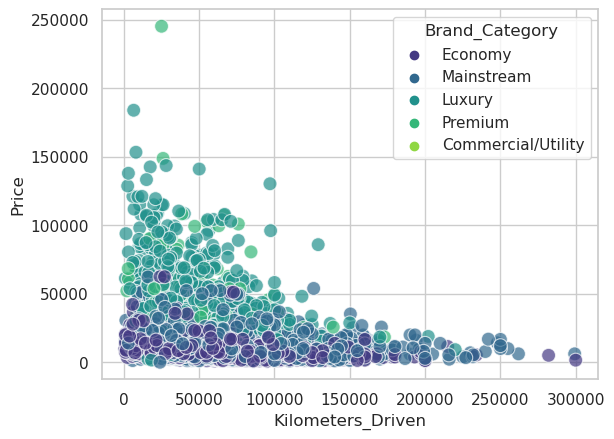

In [29]:
sns.set(style="whitegrid")
sns.scatterplot(x=df['Kilometers_Driven'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Year', ylabel='Price'>

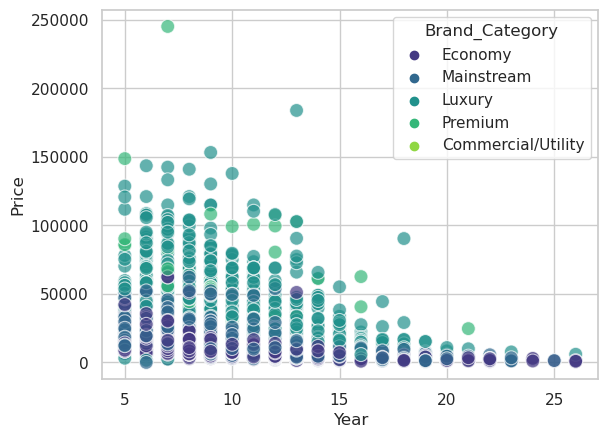

In [30]:
sns.scatterplot(x=df['Year'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Mileage', ylabel='Price'>

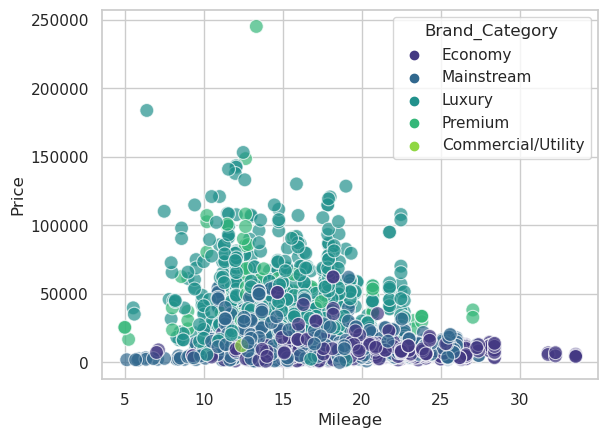

In [31]:
sns.scatterplot(x=df['Mileage'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Engine', ylabel='Price'>

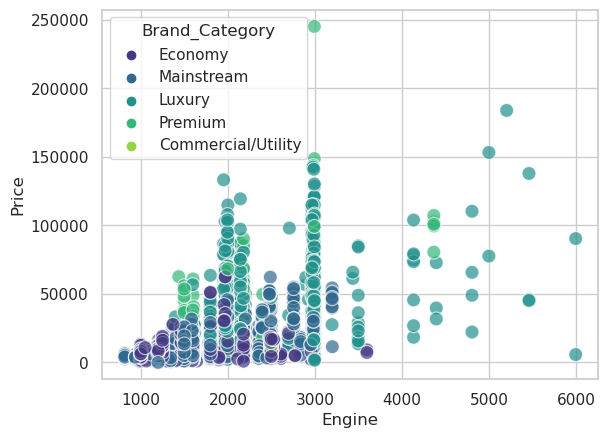

In [32]:
sns.scatterplot(x=df['Engine'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Power', ylabel='Price'>

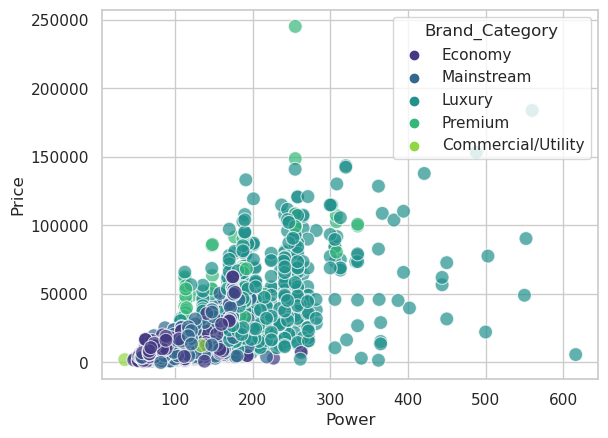

In [33]:
sns.scatterplot(x=df['Power'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6978 entries, 0 to 7252
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6978 non-null   object 
 1   Location           6978 non-null   object 
 2   Price              5972 non-null   float64
 3   Year               6978 non-null   int64  
 4   Kilometers_Driven  6978 non-null   int64  
 5   Fuel_Type          6978 non-null   object 
 6   Transmission       6978 non-null   object 
 7   Owner_Type         6978 non-null   object 
 8   Mileage            6978 non-null   float64
 9   Engine             6978 non-null   float64
 10  Power              6978 non-null   float64
 11  Seats              6978 non-null   float64
 12  Owner_Type_Num     6978 non-null   int64  
 13  Location_income    6978 non-null   object 
 14  Car_cate           6978 non-null   object 
 15  Brand              6978 non-null   object 
 16  Brand_Category     6978 

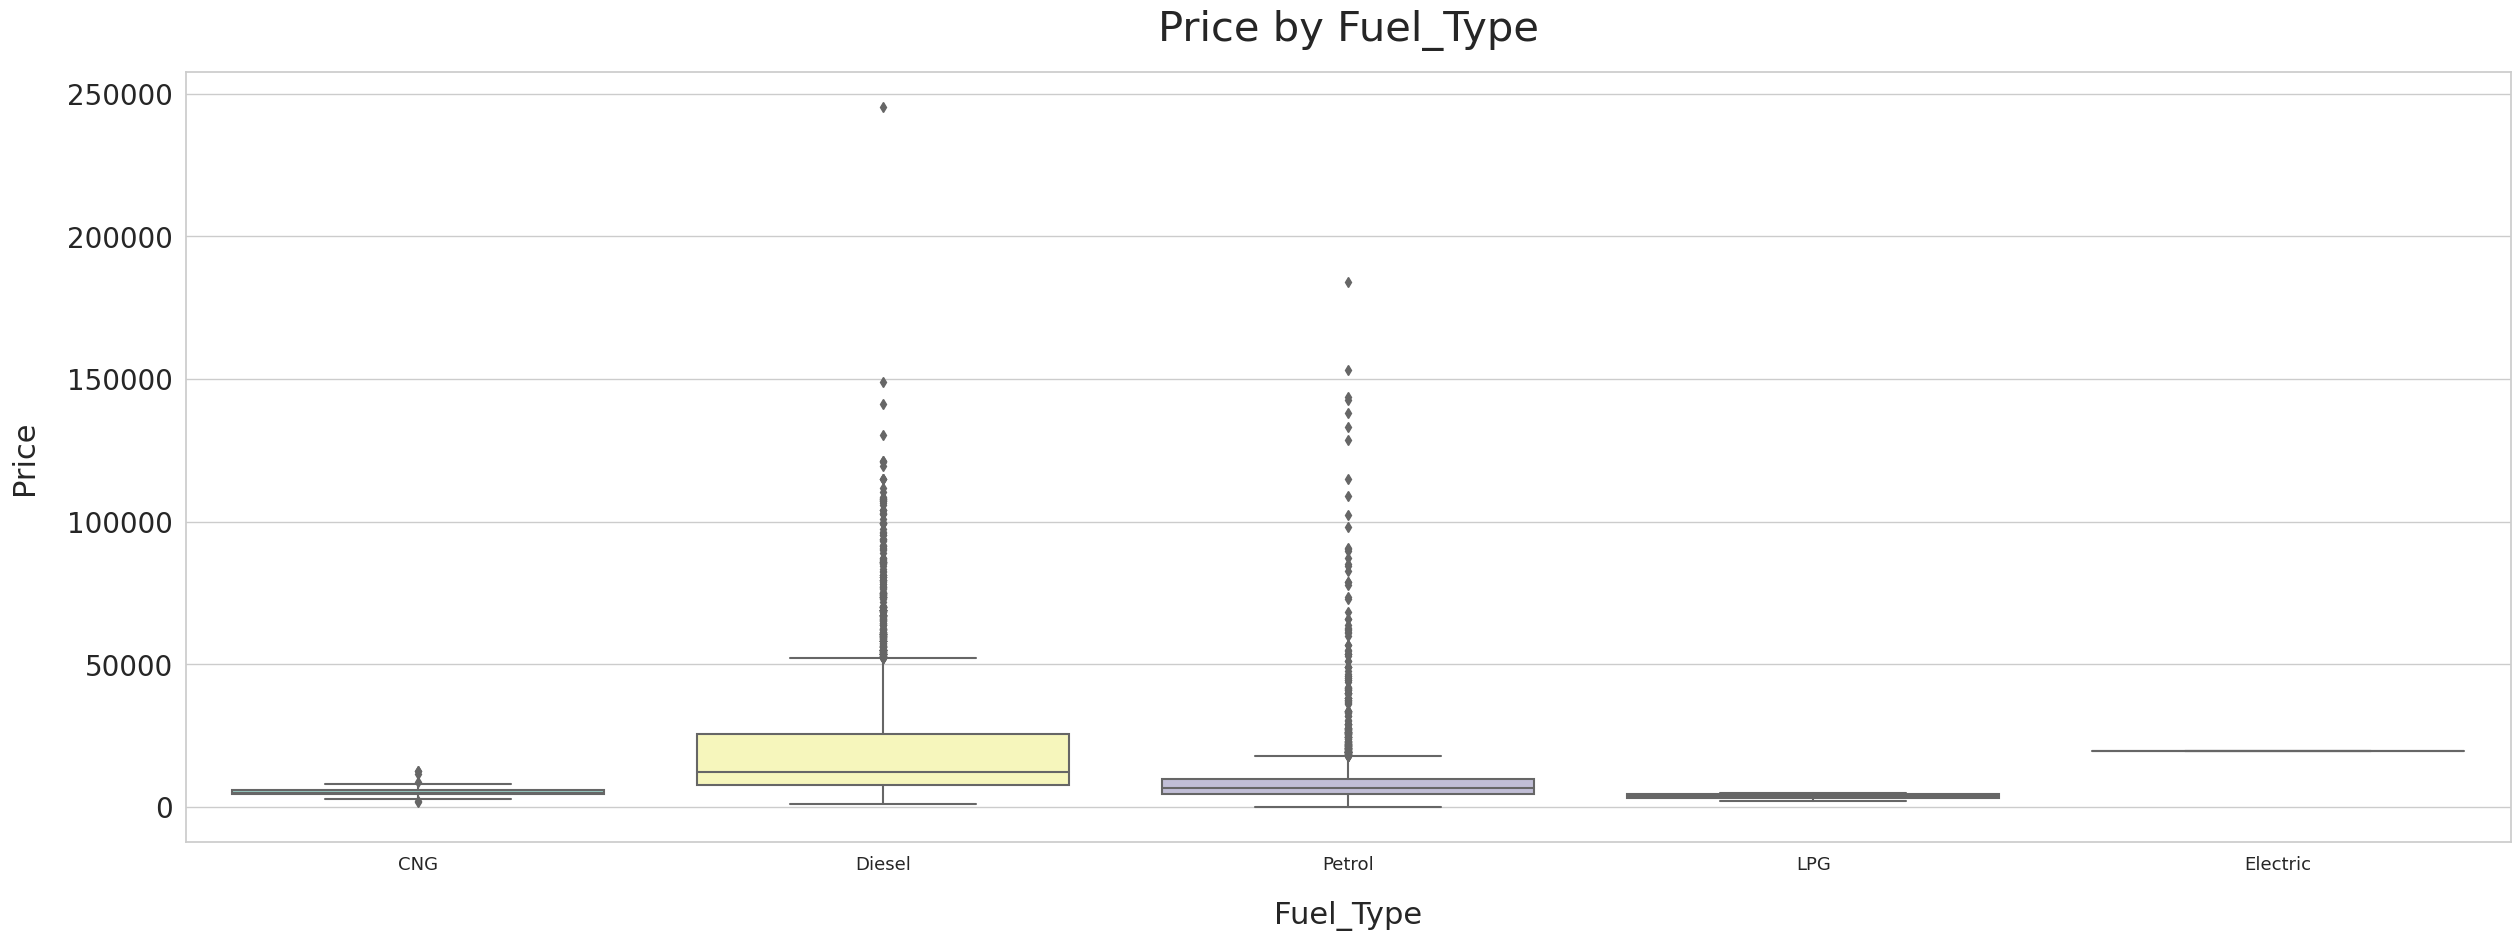

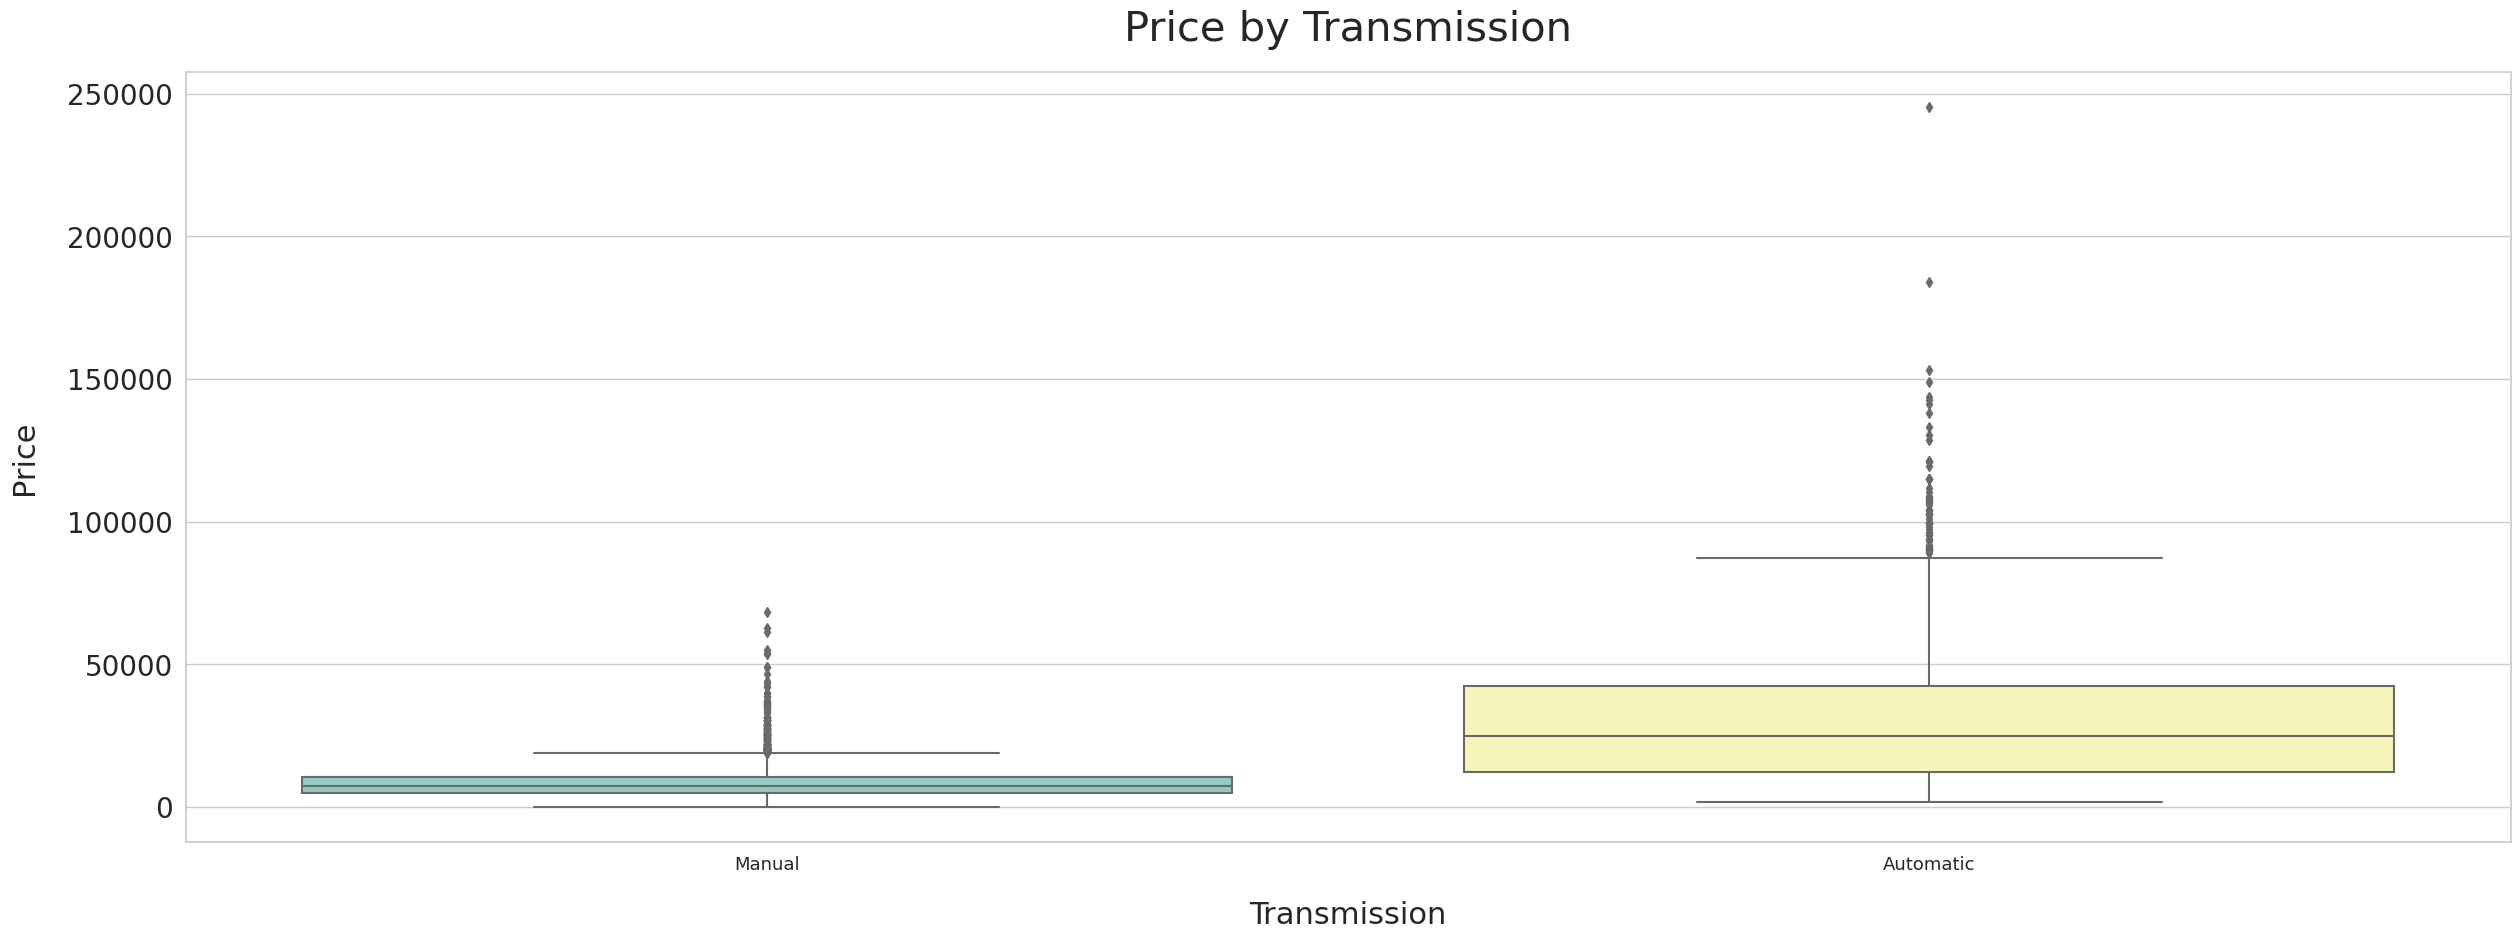

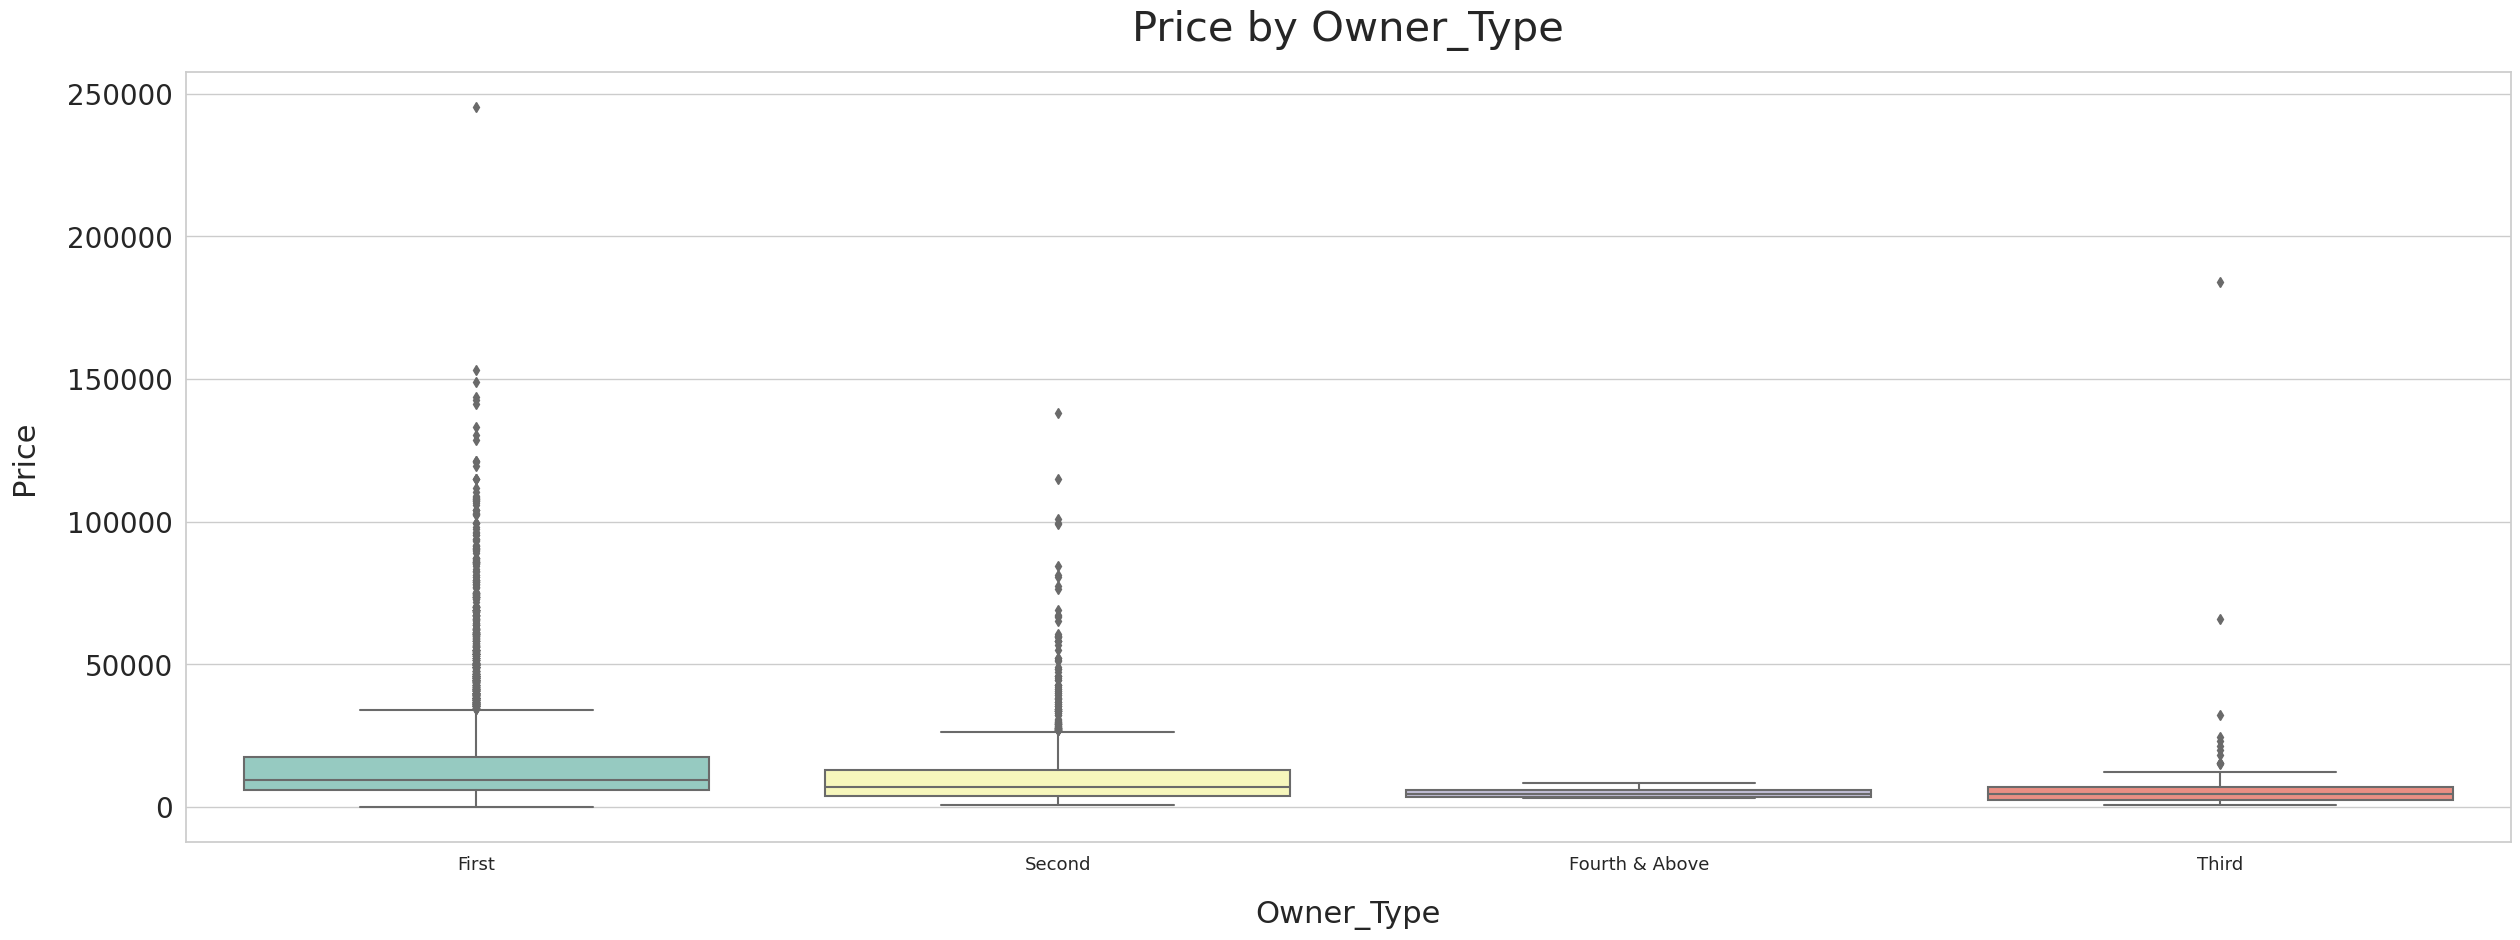

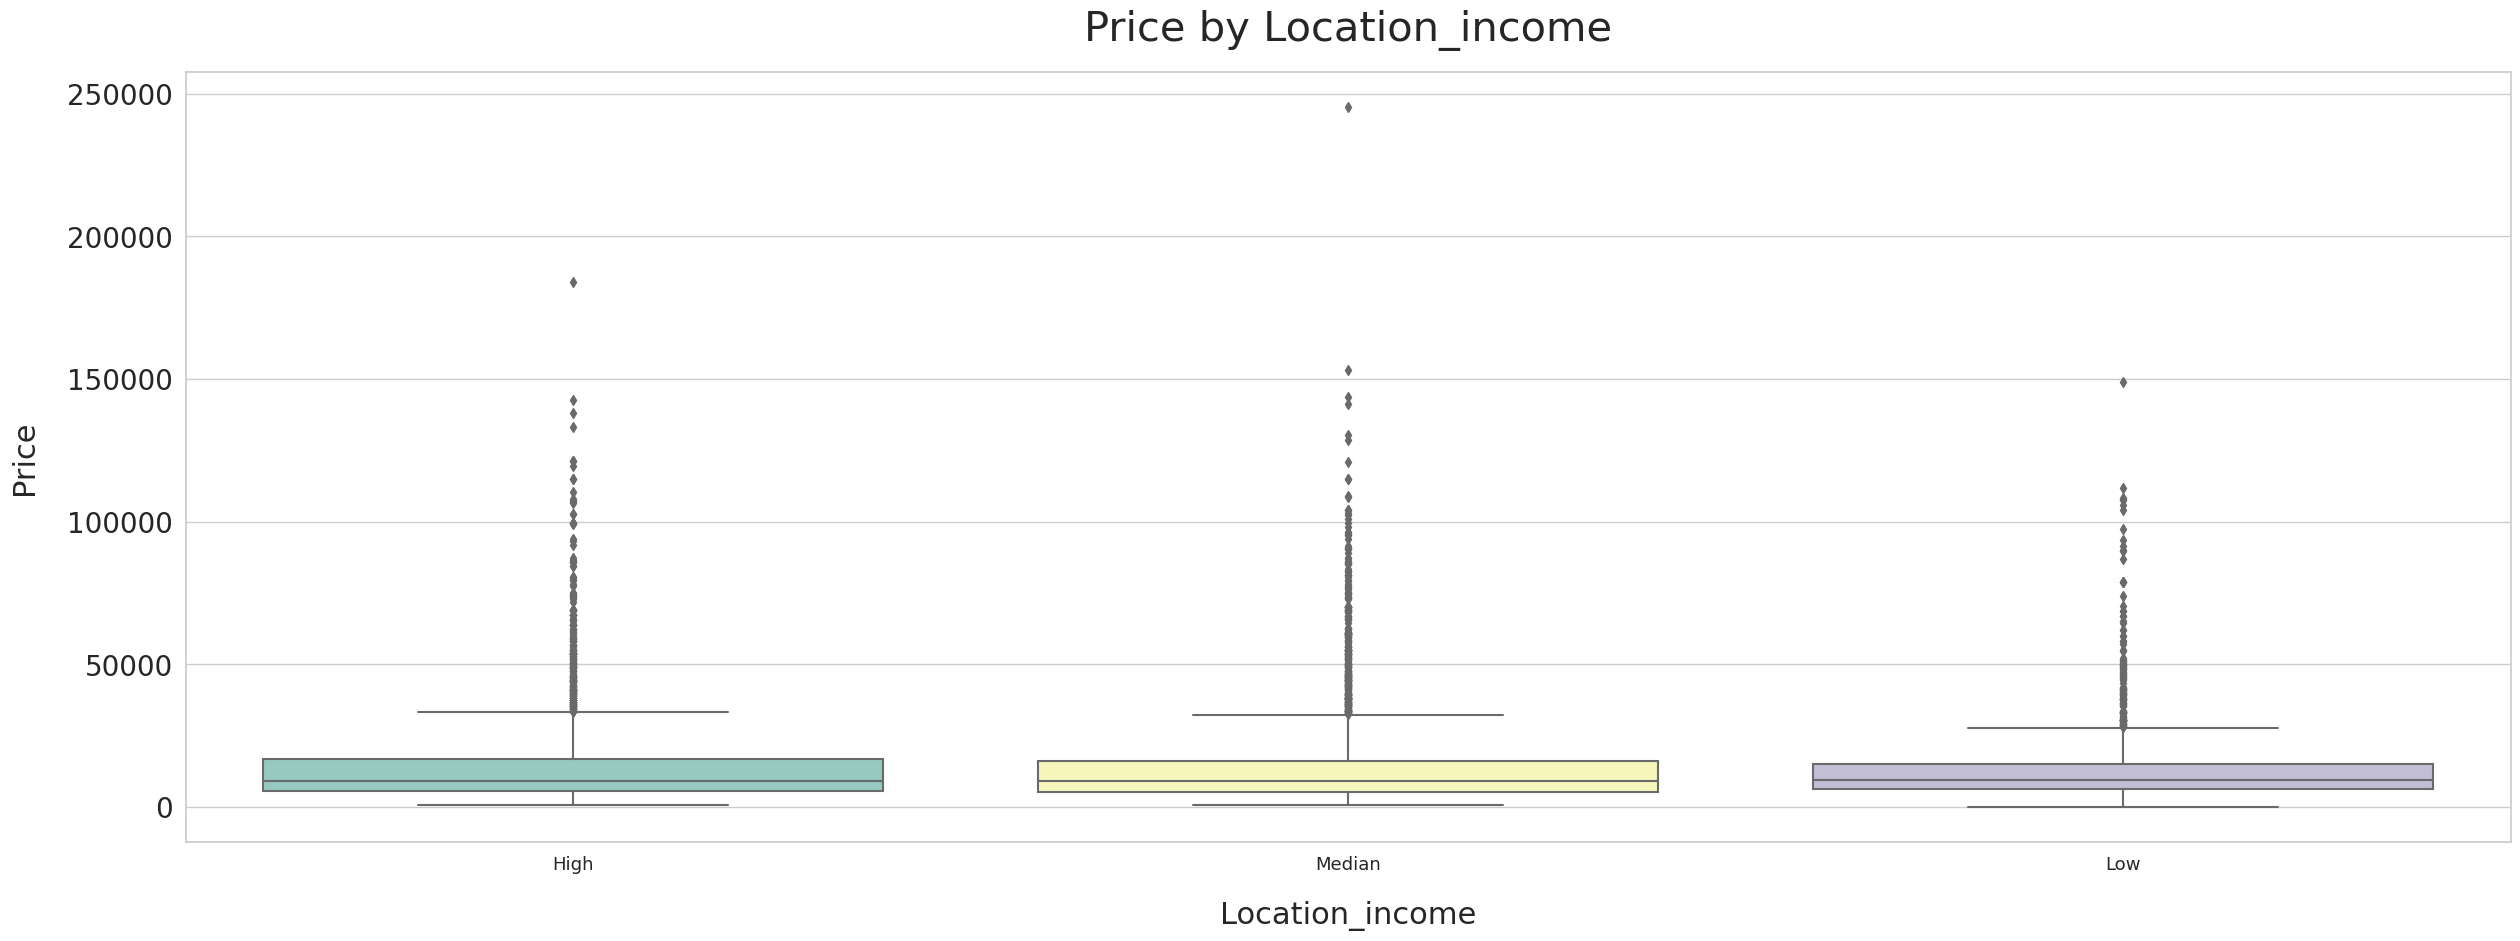

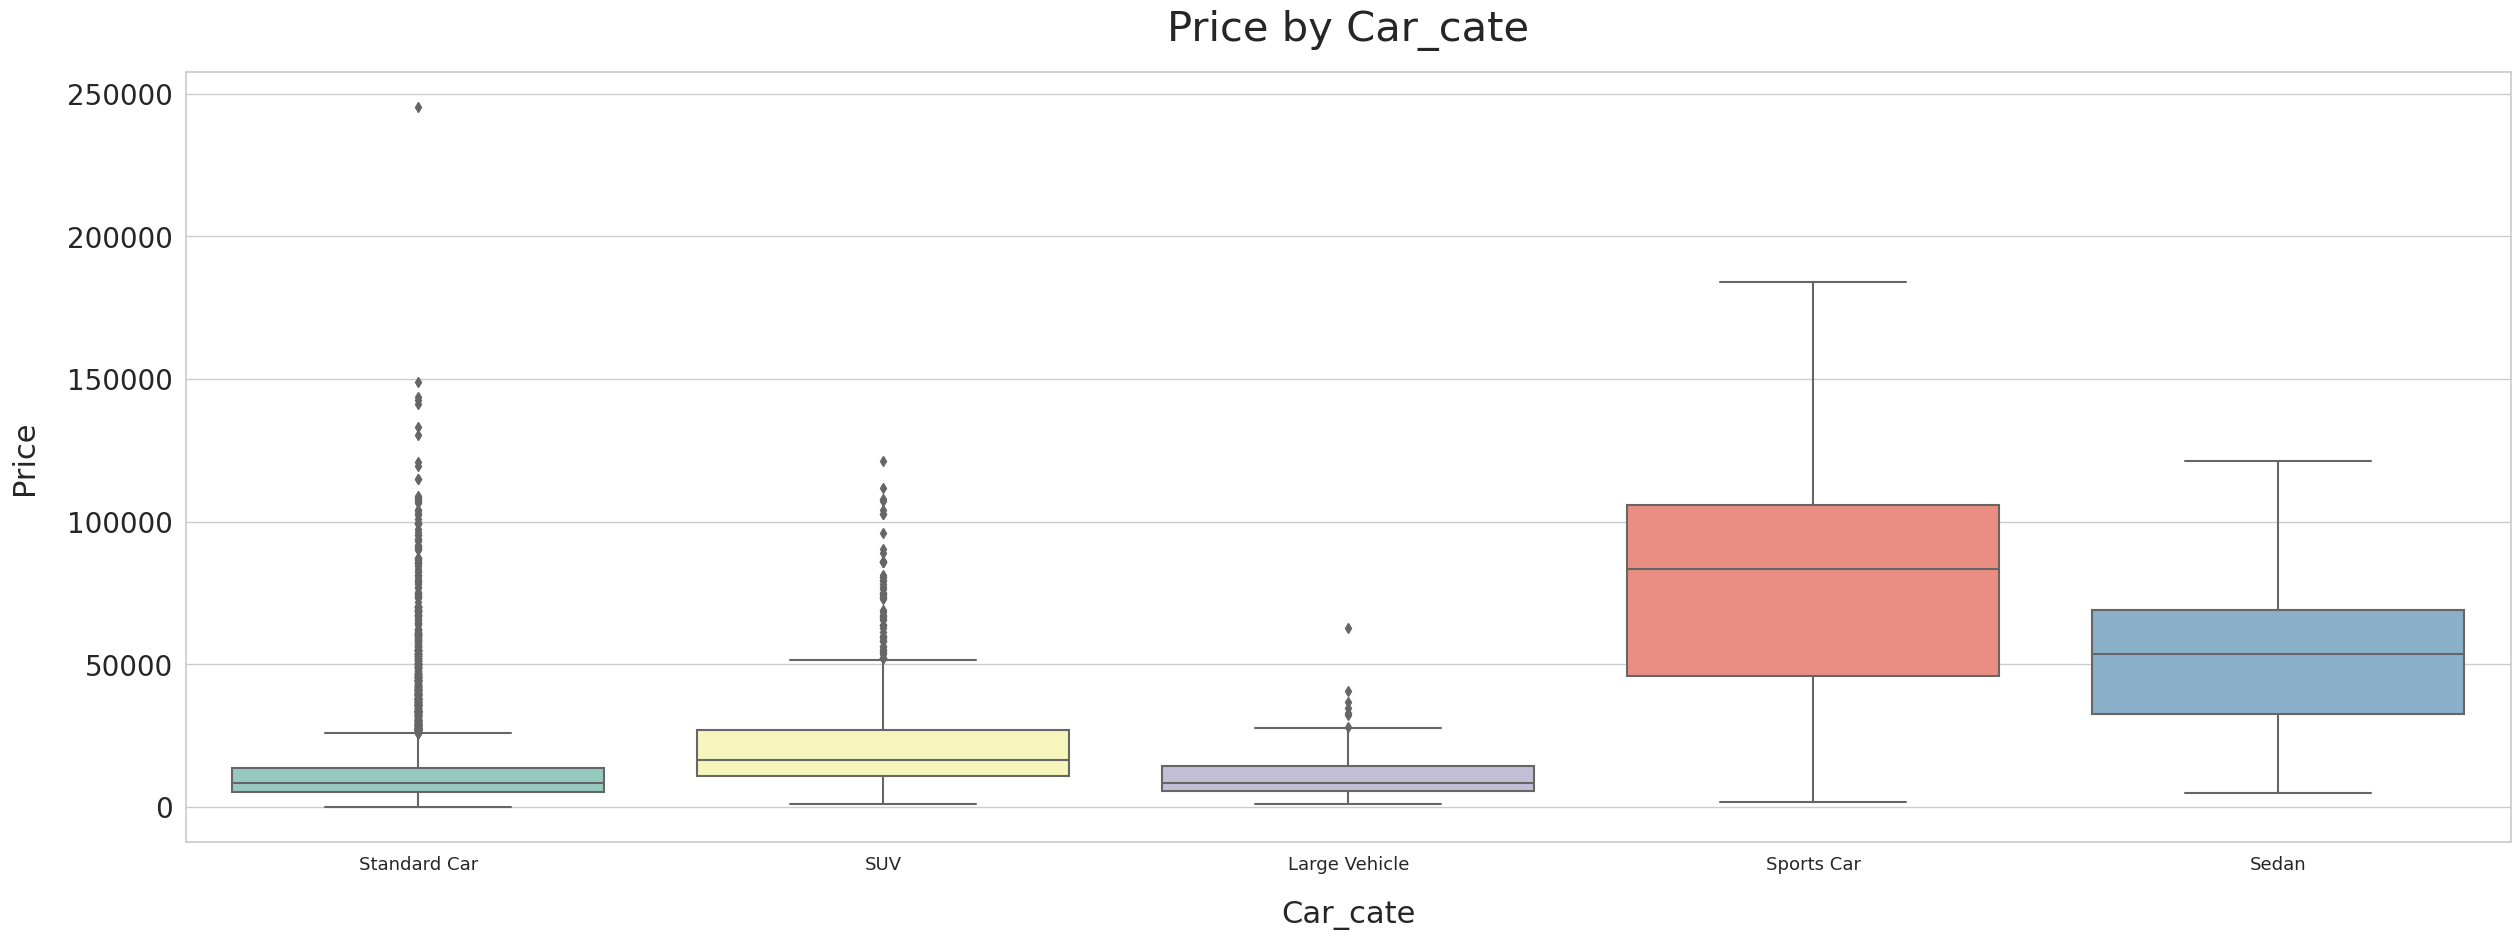

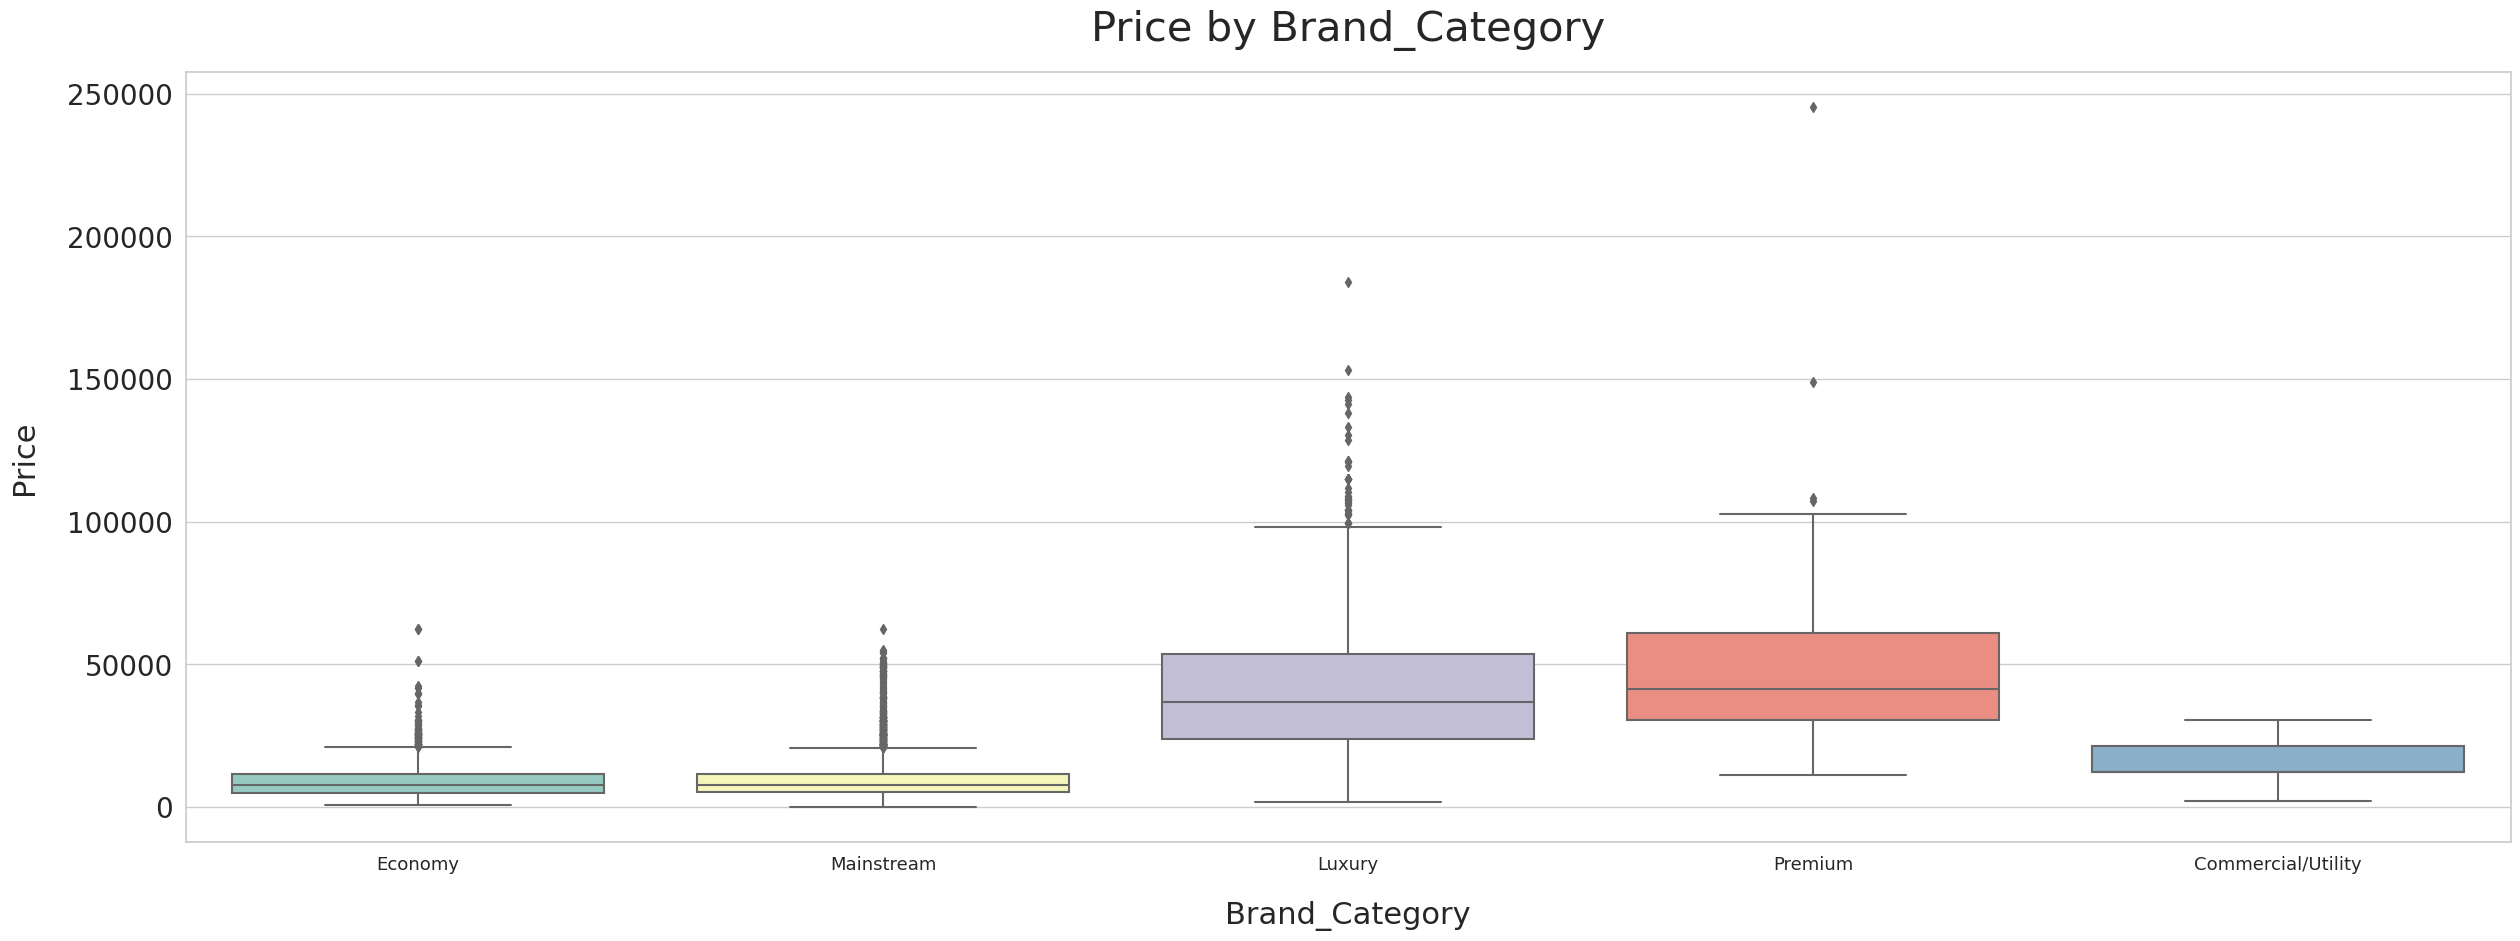

In [35]:
dummies = ["Fuel_Type", "Transmission", "Owner_Type", "Location_income", "Car_cate", "Brand_Category"]

for dum in dummies:
    plt.figure(figsize=(30,10))
    sns.set_theme(style="whitegrid")
    sns.boxplot(x=dum, y="Price", 
                data=df, palette="Set3")
    
    plt.title("Price by "+ dum, fontsize=30, y=1.03)
    
    plt.xticks(fontsize=13)
    plt.xlabel(dum, fontsize=22, labelpad=20)
    
    plt.yticks(fontsize=20)
    plt.ylabel("Price", fontsize=22, labelpad=20)
    
    plt.show()

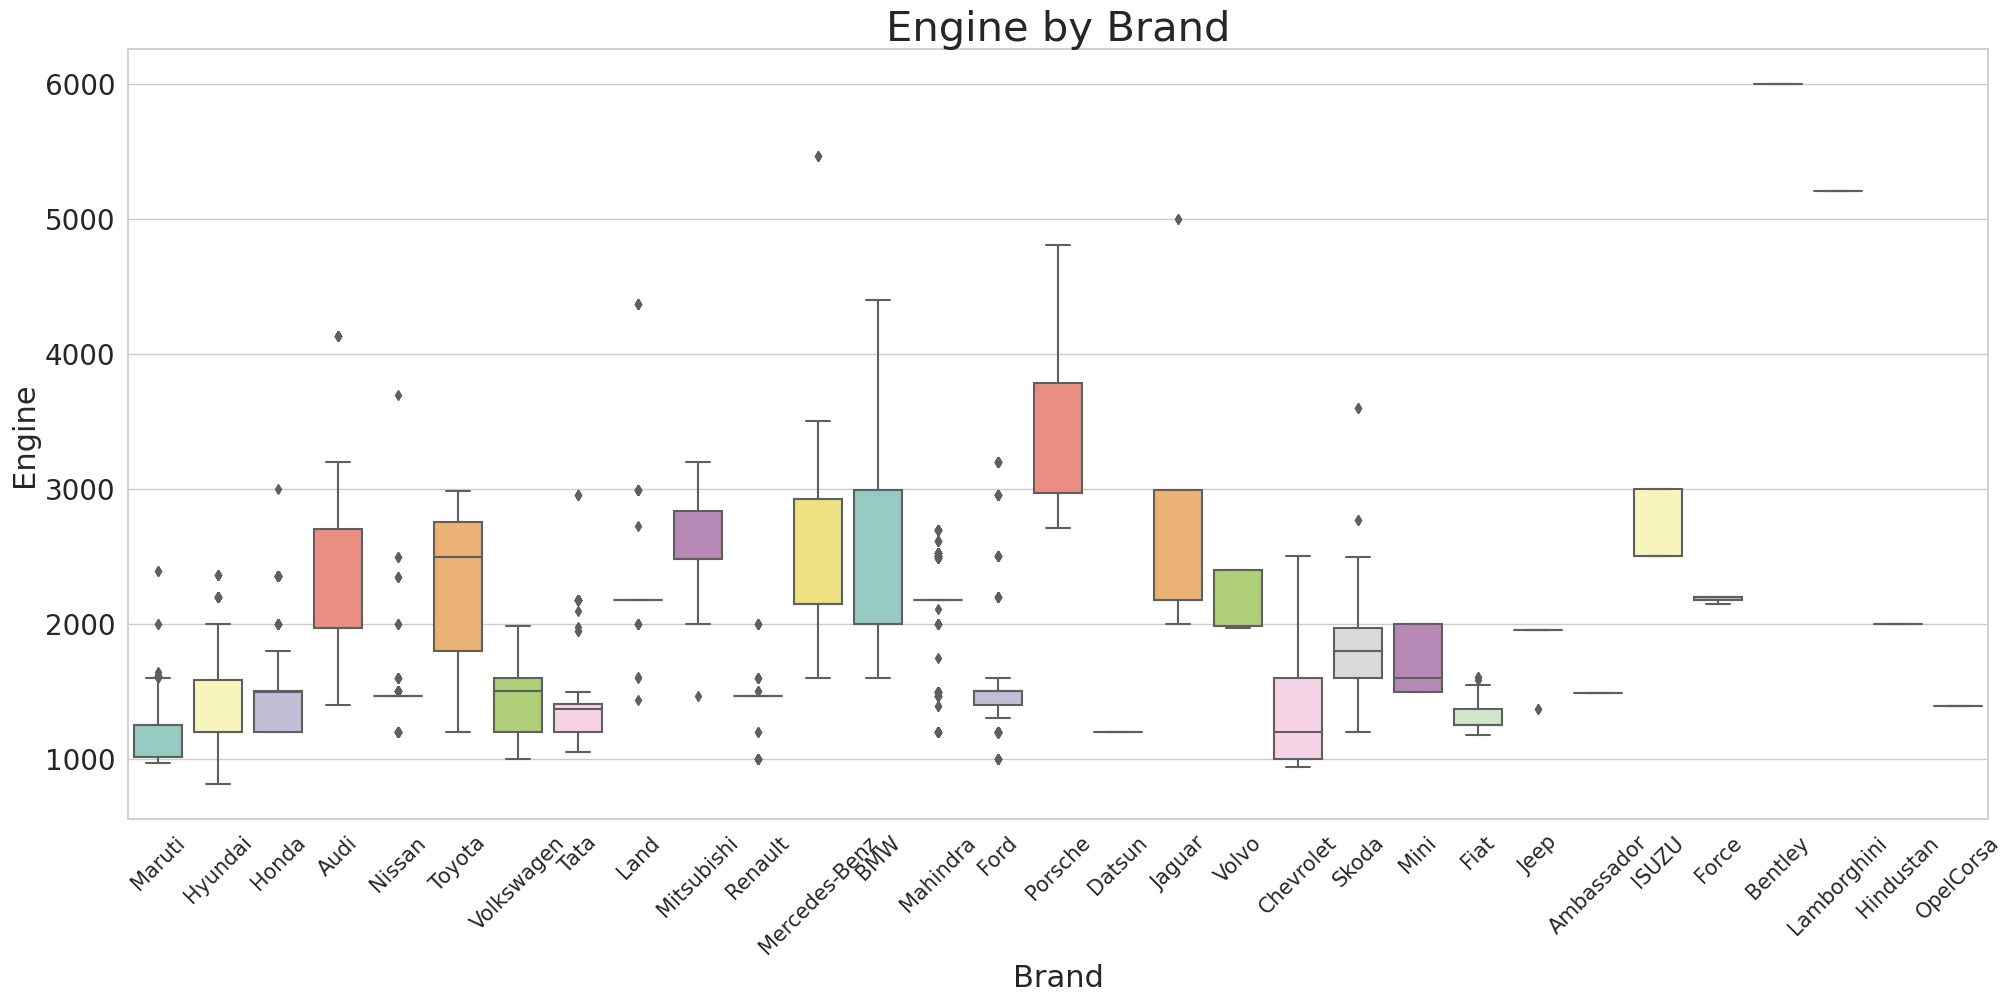

In [36]:
plt.figure(figsize=(24,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x="Brand", y="Engine", data=df, palette="Set3")

plt.title("Engine by Brand", fontsize=30)
plt.xticks(fontsize=15, rotation=45)
plt.xlabel("Brand", fontsize=22)
plt.yticks(fontsize=20)
plt.ylabel("Engine", fontsize=22)

plt.show()

In [37]:
df_mis_price = df[df['Price'].isna()]

df = df[df['Price'].notna()]

print(df_mis_price.shape)
print(df.shape)

(1006, 17)
(5972, 17)


(array([2.600e+03, 1.873e+03, 5.170e+02, 2.970e+02, 2.030e+02, 1.510e+02,
        1.020e+02, 6.000e+01, 5.400e+01, 3.100e+01, 2.200e+01, 1.800e+01,
        1.400e+01, 1.100e+01, 8.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([7.08000000e+00, 8.18263067e+03, 1.63581813e+04, 2.45337320e+04,
        3.27092827e+04, 4.08848333e+04, 4.90603840e+04, 5.72359347e+04,
        6.54114853e+04, 7.35870360e+04, 8.17625867e+04, 8.99381373e+04,
        9.81136880e+04, 1.06289239e+05, 1.14464789e+05, 1.22640340e+05,
        1.30815891e+05, 1.38991441e+05, 1.47166992e+05, 1.55342543e+05,
        1.63518093e+05, 1.71693644e+05, 1.79869195e+05, 1.88044745e+05,
        1.96220296e+05, 2.04395847e+05, 2.12571397e+05, 2.20746948e+05,
        2.28922499e+05, 2.37098049e+05, 2.45273600e+05]),
 <BarContainer object of 30 artists>)

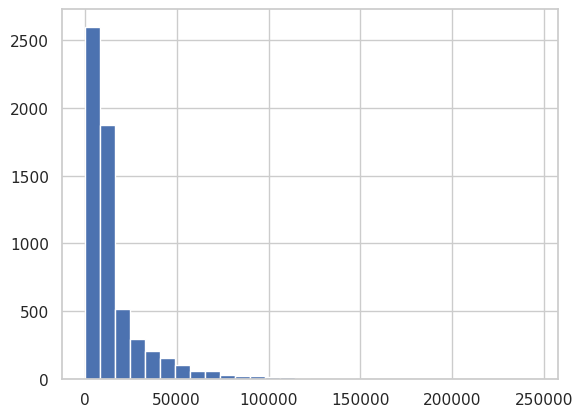

In [38]:
plt.hist(df['Price'],bins = 30)

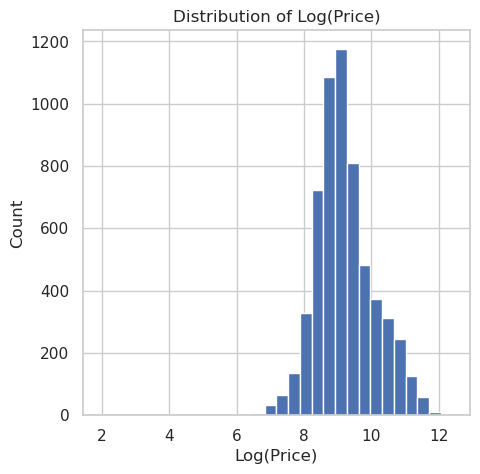

In [39]:
df['Price_log'] = np.log(df['Price'])

plt.figure(figsize=(5, 5))
plt.hist(df['Price_log'], bins=30)
plt.xlabel('Log(Price)')
plt.ylabel('Count')
plt.title('Distribution of Log(Price)')
plt.show()

In [40]:
stat, p = shapiro(df['Price_log'])
print('Shapiro-Wilk test 결과 - Statistic: {}, p-value: {}'.format(stat, p))

Shapiro-Wilk test 결과 - Statistic: 0.978207528591156, p-value: 2.6966555108428575e-29


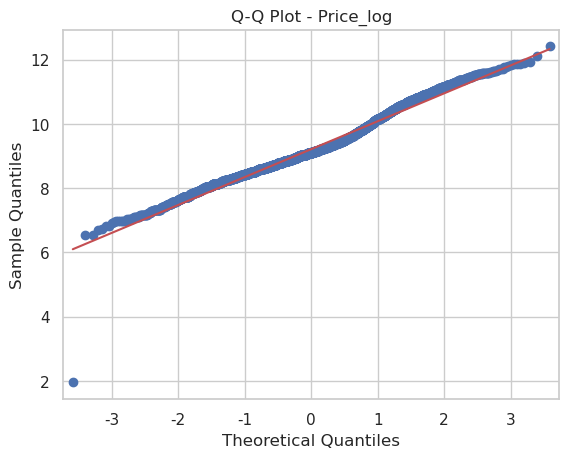

In [41]:
sm.qqplot(df['Price_log'], line='s')
plt.title('Q-Q Plot - Price_log')
plt.show()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5972 entries, 0 to 7236
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5972 non-null   object 
 1   Location           5972 non-null   object 
 2   Price              5972 non-null   float64
 3   Year               5972 non-null   int64  
 4   Kilometers_Driven  5972 non-null   int64  
 5   Fuel_Type          5972 non-null   object 
 6   Transmission       5972 non-null   object 
 7   Owner_Type         5972 non-null   object 
 8   Mileage            5972 non-null   float64
 9   Engine             5972 non-null   float64
 10  Power              5972 non-null   float64
 11  Seats              5972 non-null   float64
 12  Owner_Type_Num     5972 non-null   int64  
 13  Location_income    5972 non-null   object 
 14  Car_cate           5972 non-null   object 
 15  Brand              5972 non-null   object 
 16  Brand_Category     5972 

Text(0.5, 1.0, 'Year')

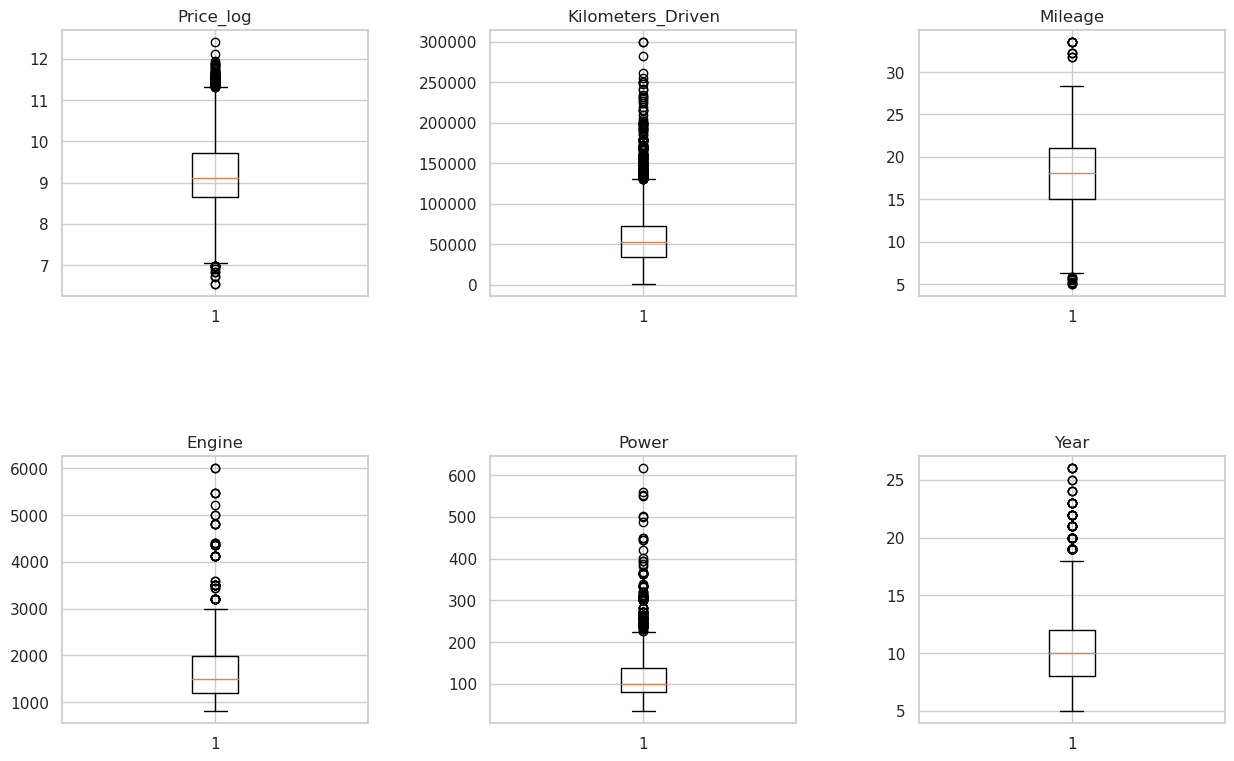

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9))
axs = axs.flatten()

fig.subplots_adjust(wspace=0.4, hspace=0.6)

axs[0].boxplot(df['Price_log'])
axs[0].set_title('Price_log')

axs[1].boxplot(df['Kilometers_Driven'])
axs[1].set_title('Kilometers_Driven')

axs[2].boxplot(df['Mileage'])
axs[2].set_title('Mileage')

axs[3].boxplot(df['Engine'])
axs[3].set_title('Engine')

axs[4].boxplot(df['Power'])
axs[4].set_title('Power')

axs[5].boxplot(df['Year'])
axs[5].set_title('Year')

> 가격값을 로그조정한후 이상치가 일부 발견되어 제거해주었습니다.

In [44]:
df.drop(df[df['Price_log'] < 3].index, inplace=True)

In [45]:
df.drop(labels = 'Location', axis = 1, inplace = True)
df.drop(labels = 'Name', axis = 1, inplace = True)
df.drop(labels = 'Seats', axis = 1, inplace = True)
df.drop(labels = 'Brand', axis = 1, inplace = True)
df.drop(labels = 'Price', axis = 1, inplace = True)

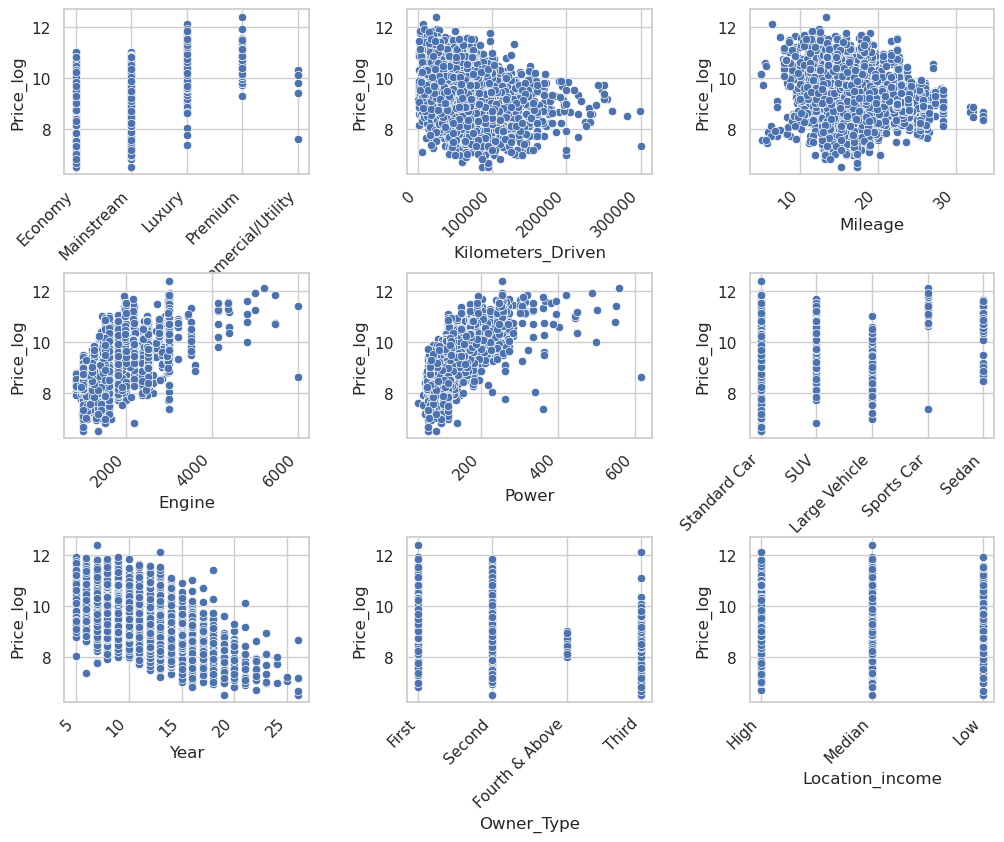

In [46]:
fig, axs = plt.subplots(3, 3, figsize=(12, 9))
axs = axs.flatten()

sns.scatterplot(data=df, x='Brand_Category', y='Price_log', ax=axs[0])
sns.scatterplot(data=df, x='Kilometers_Driven', y='Price_log', ax=axs[1])
sns.scatterplot(data=df, x='Mileage', y='Price_log', ax=axs[2])
sns.scatterplot(data=df, x='Engine', y='Price_log', ax=axs[3])
sns.scatterplot(data=df, x='Power', y='Price_log', ax=axs[4])
sns.scatterplot(data=df, x='Car_cate', y='Price_log', ax=axs[5])
sns.scatterplot(data=df, x='Year', y='Price_log', ax=axs[6])
sns.scatterplot(data=df, x='Owner_Type', y='Price_log', ax=axs[7])
sns.scatterplot(data=df, x='Location_income', y='Price_log', ax=axs[8])

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

fig.subplots_adjust(wspace=0.4, hspace=0.6)

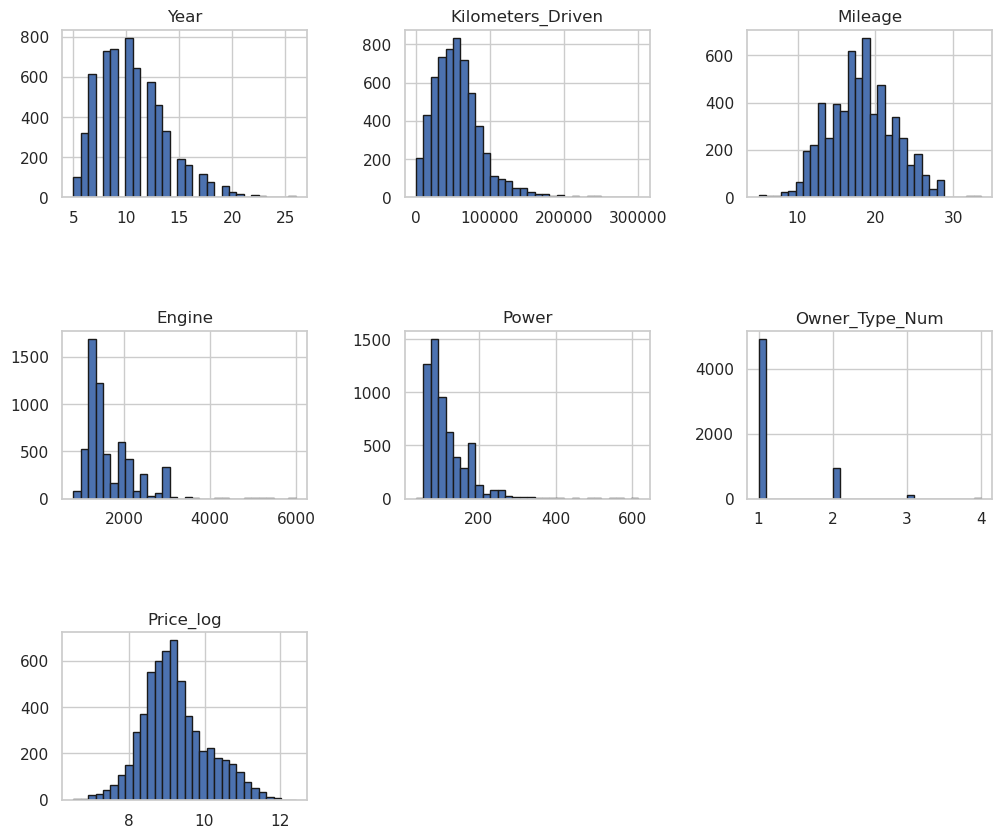

In [47]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

df.hist(ax=ax, bins=30, figsize=(12, 10), edgecolor='k')

fig.subplots_adjust(wspace=0.4, hspace=0.8)

plt.show()

<Axes: >

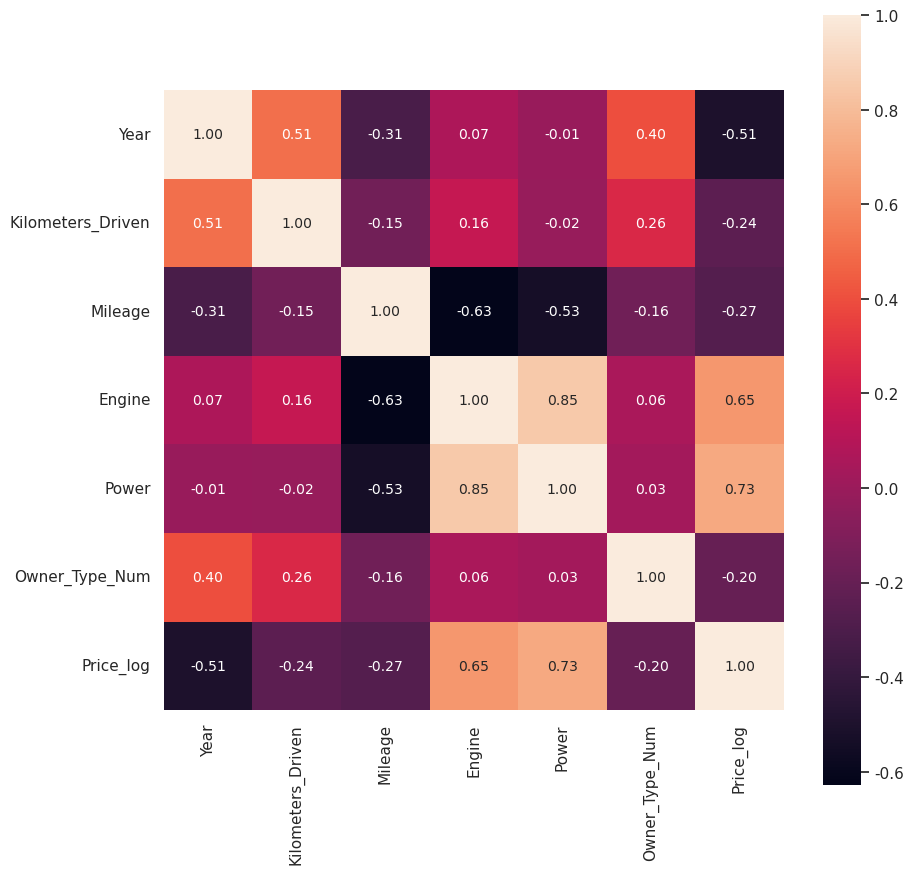

In [48]:
df_raw = df.select_dtypes(include=np.number)
plt.figure(figsize=(10, 10))
sns.heatmap(df_raw.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [49]:
df.corr().round(3)

,Year,Kilometers_Driven,Mileage,Engine,Power,Owner_Type_Num,Price_log
Year,1.000,0.507,-0.310,0.067,-0.005,0.399,-0.507
Kilometers_Driven,0.507,1.000,-0.152,0.164,-0.016,0.258,-0.236
Mileage,-0.310,-0.152,1.000,-0.628,-0.535,-0.160,-0.267
Engine,0.067,0.164,-0.628,1.000,0.850,0.056,0.652
Power,-0.005,-0.016,-0.535,0.850,1.000,0.028,0.726
Owner_Type_Num,0.399,0.258,-0.160,0.056,0.028,1.000,-0.201
Price_log,-0.507,-0.236,-0.267,0.652,0.726,-0.201,1.000


In [50]:
df_char=df.select_dtypes(include="object")
df_numeric=df.select_dtypes(exclude="object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)
df_encoded = pd.get_dummies(df_char, drop_first=True)

df_final = df_numeric_scaled.join(df_encoded)

In [51]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1234) 
print('train data size : {}'.format(df_train.shape)) 
print('test data size : {}'.format(df_test.shape))

train data size : (4179, 13)
test data size : (1792, 13)


In [52]:
reg_model = smf.ols(
    formula='Price_log ~ Power + Kilometers_Driven + Mileage + Engine + Year', 
    data=df_train
)

reg_result = reg_model.fit()

print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_log   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3246.
Date:                Fri, 09 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:20:43   Log-Likelihood:                -2000.4
No. Observations:                4179   AIC:                             4013.
Df Residuals:                    4173   BIC:                             4051.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             9.1345      0.06

In [53]:
df_vif = pd.DataFrame()
df_vif['variable'] = df_numeric_scaled.columns
df_vif["VIF"] = [variance_inflation_factor(df_numeric_scaled.values, i) for i in range(df_numeric_scaled.shape[1])]

print(df_vif.sort_values('VIF', ascending=True).round(2))

            variable   VIF
5     Owner_Type_Num  1.20
1  Kilometers_Driven  1.53
2            Mileage  1.92
0               Year  2.98
6          Price_log  4.99
3             Engine  5.15
4              Power  5.21


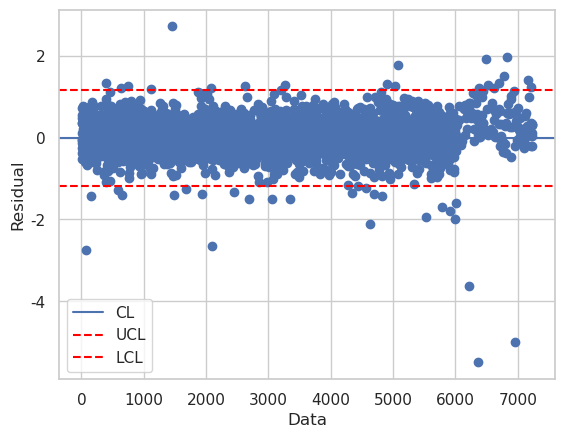

In [54]:
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data") ; plt.ylabel('Residual')
plt.axhline(y = 0, linestyle='-', label = 'CL')
plt.axhline(y = 3*np.std(reg_result.resid),linestyle = '--', color = 'red', label='UCL')
plt.axhline(y = -3*np.std(reg_result.resid),linestyle = 'dashed', color = 'red', label='LCL')
plt.legend()
plt.show()

In [55]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print('train data 의 결정계수:', r2_score(df_train['Price_log'],train_pred))
print('test data의 결정계수:', r2_score(df_test['Price_log'], test_pred))

train data 의 결정계수: 0.7954616454485524
test data의 결정계수: 0.805487136835901


In [56]:
df_x = df_numeric_scaled.drop("Price_log", axis = 1, inplace = False)
df_y = df_numeric_scaled["Price_log"] 

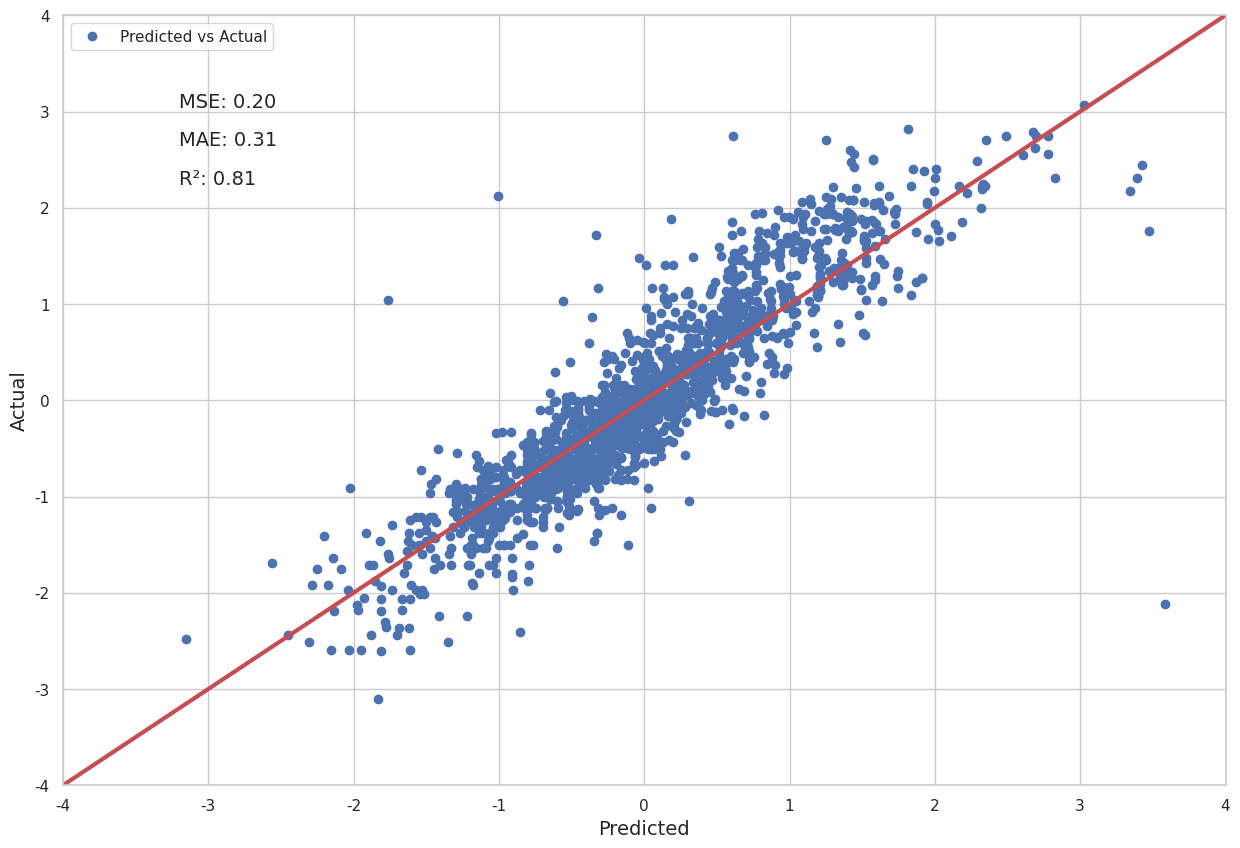

In [62]:
def get_graph(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    predicted = reg.predict(X_test)
    actual = y_test

    act_df = pd.DataFrame(actual)
    pred_df = pd.DataFrame(predicted)

    act_df.reset_index(inplace=True)

    act_pred_df = pd.concat([act_df, pred_df], axis=1)
    act_pred_df.columns = ['index', 'actual', 'predicted']

    # 성능 지표 계산
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    # 그래프 생성
    plt.figure(figsize=(15, 10))
    plt.plot(act_pred_df['predicted'], act_pred_df['actual'], 'o', label='Predicted vs Actual')

    # 성능 지표를 텍스트로 그래프에 추가
    plt.text(0.1, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.85, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.8, f'R²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.axis([-4, 4, -4, 4])
    line = plt.plot([-4, 4], [-4, 4], color='r', linewidth=3.0)
    plt.legend()
    plt.show()

# 함수 호출
get_graph(df_x, df_y)

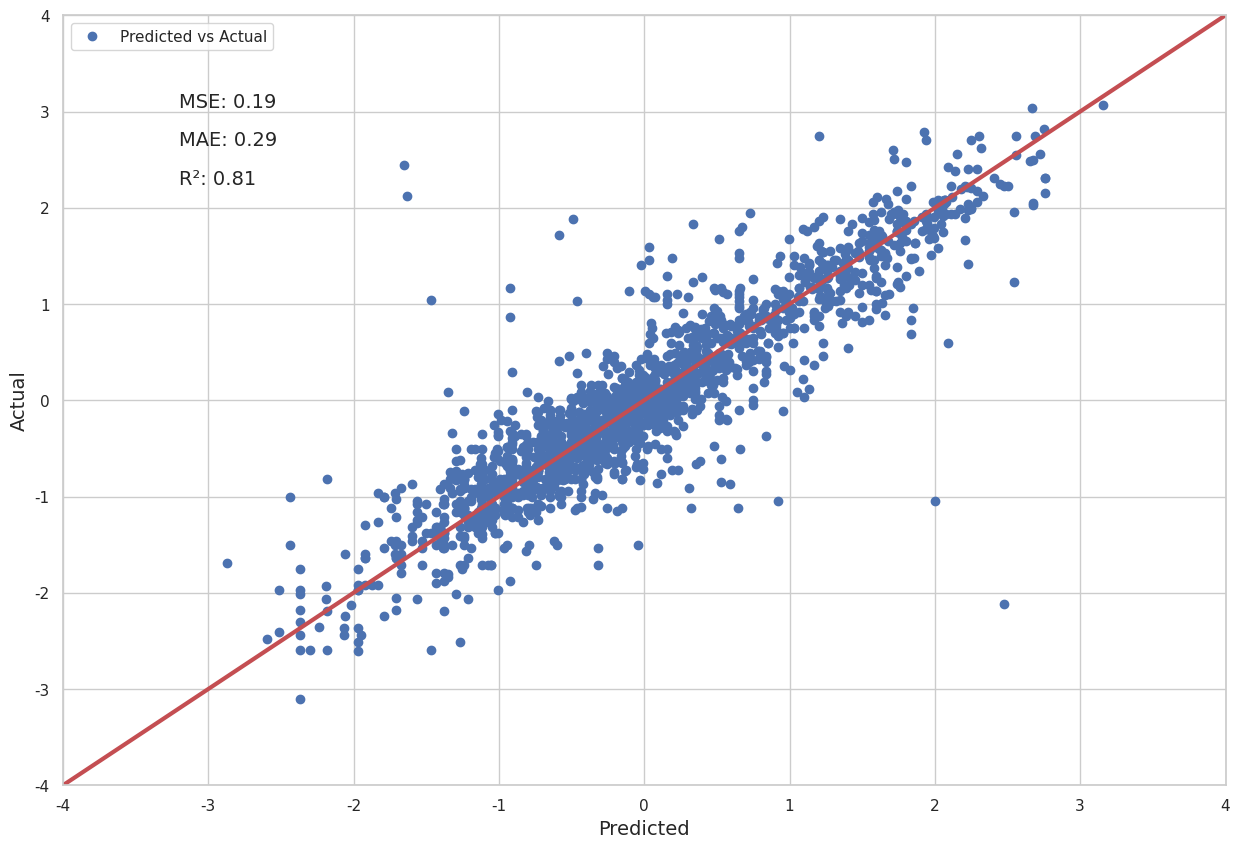

In [63]:
def get_graph_dt(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
    dt_reg = DecisionTreeRegressor(random_state=1234)
    dt_reg.fit(X_train, y_train)

    predicted = dt_reg.predict(X_test)
    actual = y_test

    act_df = pd.DataFrame(actual)
    pred_df = pd.DataFrame(predicted)

    act_df.reset_index(inplace=True)

    act_pred_df = pd.concat([act_df, pred_df], axis=1)
    act_pred_df.columns = ['index', 'actual', 'predicted']

    # 성능 지표 계산
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    # 그래프 생성
    plt.figure(figsize=(15, 10))
    plt.plot(act_pred_df['predicted'], act_pred_df['actual'], 'o', label='Predicted vs Actual')

    # 성능 지표를 텍스트로 그래프에 추가
    plt.text(0.1, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.85, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.8, f'R²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.axis([-4, 4, -4, 4])
    line = plt.plot([-4, 4], [-4, 4], color='r', linewidth=3.0)
    plt.legend()
    plt.show()
    
get_graph_dt(df_x,df_y)

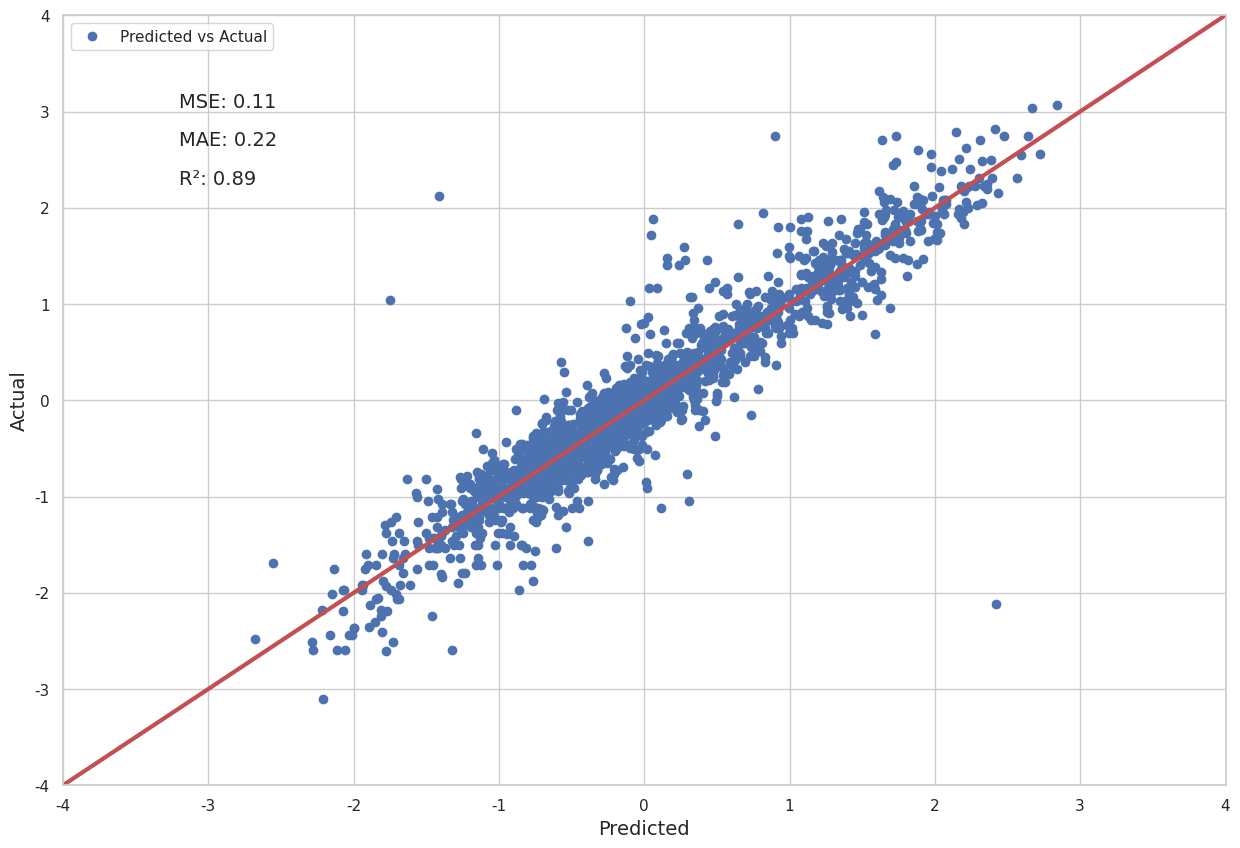

In [64]:
def get_graph_rf(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
    rf_reg = RandomForestRegressor(random_state=1234)
    rf_reg.fit(X_train, y_train)

    predicted = rf_reg.predict(X_test)
    actual = y_test

    act_df = pd.DataFrame(actual)
    pred_df = pd.DataFrame(predicted)

    act_df.reset_index(inplace=True)

    act_pred_df = pd.concat([act_df, pred_df], axis=1)
    act_pred_df.columns = ['index', 'actual', 'predicted']

    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    plt.figure(figsize=(15, 10))
    plt.plot(act_pred_df['predicted'], act_pred_df['actual'], 'o', label='Predicted vs Actual')

    plt.text(0.1, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.85, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.8, f'R²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.axis([-4, 4, -4, 4])
    line = plt.plot([-4, 4], [-4, 4], color='r', linewidth=3.0)
    plt.legend()
    plt.show()

get_graph_rf(df_x,df_y)

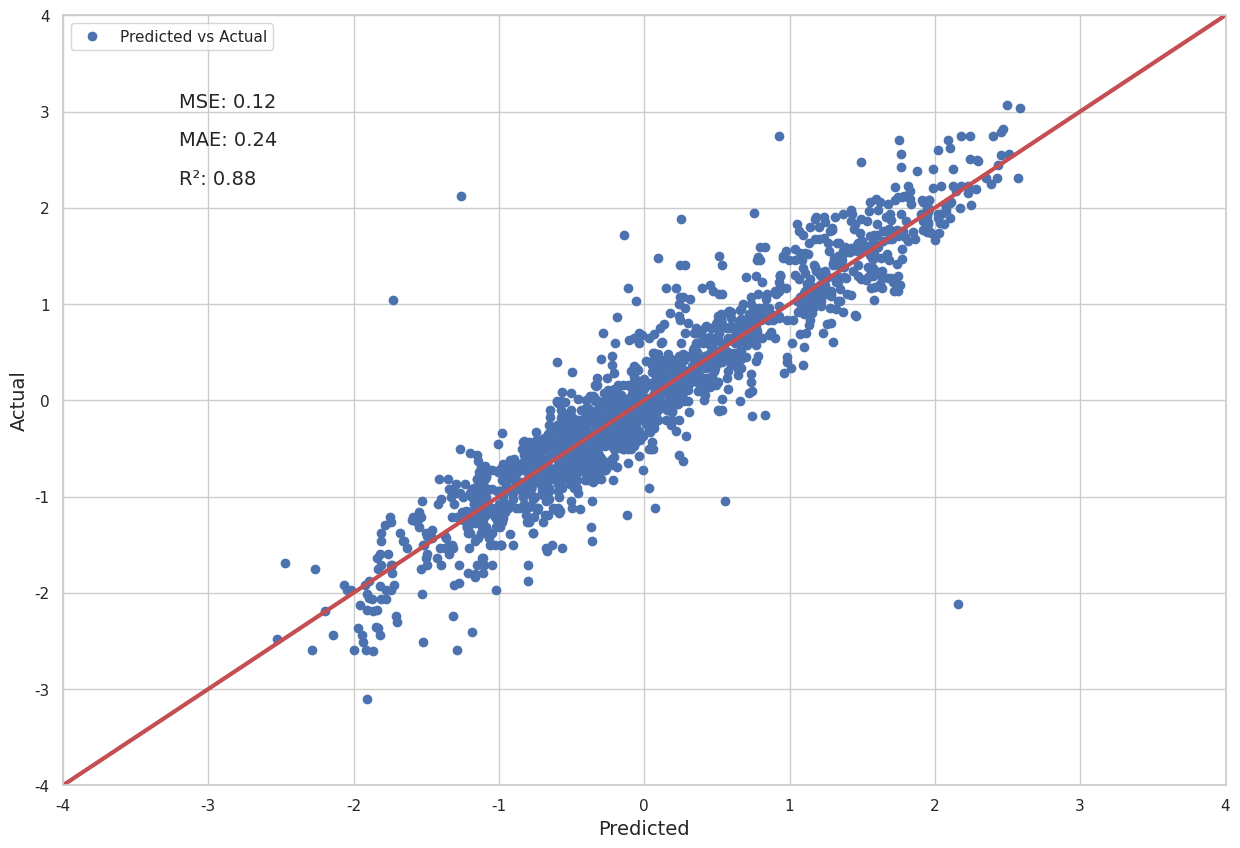

In [65]:
def get_graph_gb(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
    gb_reg = GradientBoostingRegressor(random_state=1234)
    gb_reg.fit(X_train, y_train)

    predicted = gb_reg.predict(X_test)
    actual = y_test

    act_df = pd.DataFrame(actual)
    pred_df = pd.DataFrame(predicted)

    act_df.reset_index(inplace=True)

    act_pred_df = pd.concat([act_df, pred_df], axis=1)
    act_pred_df.columns = ['index', 'actual', 'predicted']

    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    plt.figure(figsize=(15, 10))
    plt.plot(act_pred_df['predicted'], act_pred_df['actual'], 'o', label='Predicted vs Actual')

    plt.text(0.1, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.85, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.text(0.1, 0.8, f'R²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.axis([-4, 4, -4, 4])
    line = plt.plot([-4, 4], [-4, 4], color='r', linewidth=3.0)
    plt.legend()
    plt.show()

get_graph_gb(df_x,df_y)

In [61]:
# reg_model = smf.ols(formula = 'Y ~ AGE + GENDER + BMI + BP + CHOLESTEROL + LDL + HDL + TCH + LTG + GLUCOSE', data = df_train)
# reg_result = reg_model.fit()
# print(reg_result.summary())